In [65]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [66]:
class NeuralNetwork(object):
    def __init__(self, hiddenSize, inputSize, outputSize):
        # initiate layers
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.hiddenSize = hiddenSize

        layers = [self.inputSize] + self.hiddenSize + [self.outputSize]

        # initiate weights
        weights = []
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            weights.append(w)
        self.weights = weights

        # initiate weights_t-1
        self.flag = False
        self.weights_last  = np.copy(self.weights)


        # initiate bias
        bias = []
        for i in range(len(layers)-1):
            b = np.random.rand(layers[i+1])
            bias.append(b)
        self.bias = bias        

        # initiate bias_t-1
        self.bias_last  = np.copy(self.bias)


        # initiate activations
        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i])
            activations.append(a)
        self.activations = activations

        # initiate gradient_w
        derivatives = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i], layers[i + 1]))
            derivatives.append(d)
        self.derivatives_w = derivatives

        # initiate gradient_b
        self.derivatives_b = np.copy(self.derivatives_w)

        # initiate average_err
        self.average_err = []

    def sigmoid(self, s, deriv=False):
        if (deriv == True):
            return s * (1-s)
        return 1/(1 + np.exp(-s))

    def feedForward(self, X):
        activations = X
        self.activations[0] = X
        for i, w in enumerate(self.weights):
            # calculate NN_input
            v = np.dot(activations, w)
            # calculate the activations
            b = self.bias[i]
            activations = self.sigmoid(v)
            self.activations[i+1] = activations
        return activations

    def backPropagate(self, error):
        for i in reversed(range(len(self.derivatives_w))):

            # get activation for previous layer
            activations = self.activations[i+1]

            # apply sigmoid derivative function
            delta = error * self.sigmoid(activations, deriv=True)

            # reshape delta as to have it as a 2d array
            delta_re = delta.reshape(delta.shape[0], -1).T

            # get activations for current layer
            current_activations = self.activations[i]

            # reshape activations as to have them as a 2d column matrix
            current_activations = current_activations.reshape(
                current_activations.shape[0], -1)

            # create matrix one of bias
            delta_bias = np.ones(activations.shape)
            #print("---------")
            #print(activations.shape)
            #print(delta_re.shape)

            # save derivative after applying matrix multiplication
            self.derivatives_w[i] = np.dot(current_activations, delta_re)
            self.derivatives_b[i] = np.dot(delta_re,delta_bias)

            # backpropogate the next error
            error = np.dot(delta, self.weights[i].T)

    def train(self, x, y, epochs, learning_rate,momentumRate):
        # now enter the training loop
        for i in range(epochs):
            sum_errors = 0

            # Random data
            data = np.concatenate([x,y] , axis=1)
            np.random.shuffle(data)
            Y = data[:,8:]
            X = data[:,:8]

            # iterate through all the training data
            for j, input in enumerate(X):
                target = Y[j]

                # activate the network!
                output = self.feedForward(input)

                error = target - output
                #print(output, " - ", target)
                self.backPropagate(error)
                # now perform gradient descent on the derivatives
                # (this will update the weights
                    
                self.gradient_descent(learning_rate,momentumRate)
                
                # keep track of the MSE for reporting later
                sum_errors += self._mse(target, output)
            #if np.all(np.subtract(self.weights,self.weights_last) != 0):
            if self.flag :
                self.weights_last = np.copy(self.weights)
                self.bias_last = np.copy(self.bias)
            self.flag = True
            # Epoch complete, report the training error
            print("Error: {} at epoch {}".format(round(sum_errors / len(X) , 5), i+1))
            self.average_err.append(round(sum_errors / len(X) , 7))

        print("Training complete! : ",sum_errors/len(X))
        print("=====")

    def gradient_descent(self, learningRate=1,momentumRate=1):
        # update the weights by stepping down the gradient
        for i in range(len(self.weights)):

            weights = self.weights[i]
            weights_last = self.weights_last[i]

            bias = self.bias[i]
            bias_last = self.bias_last[i]

            derivatives_w = self.derivatives_w[i]
            derivatives_b = self.derivatives_b[i]

            
            #print(weights-weights_last)
            weights += (derivatives_w * learningRate) + ((weights-weights_last)*momentumRate)
            #print("---")
            #print(bias.shape)
            #print(derivatives_b.shape)
            #print(bias_last.shape)
            bias += (derivatives_b * learningRate) + ((bias-bias_last)*momentumRate)
            
            

    def _mse(self, target, output):
        return np.average((target - output) ** 2)


In [67]:
def convert_output(max,min,data,flag = False):
    if flag == True:
        return  ( data*(max-min)) + min
    return  (data - min) / (max - min)

In [68]:
def convert_input(data):
    mean = data.mean(axis = 0)
    sd = data.std(axis = 0)
    return (data- mean)/ sd

In [69]:
def Preprocessing_Flood():

        # import data set
        with open("Flood_dataset.txt", "r") as f:
            content = f.readlines()
        del content[0:3]

        # split data set
        data = []
        for X in content:
            data.append(X.split())

        # convert data to list 
        output = [list(map(int, X[8:])) for X in data]
        input = [list(map(int, X[:8])) for X in data]
        data = [list(map(int, X[:9])) for X in data]

        input = np.array(input)
        output = np.array(output)
        max,min = output.max(),output.min()

        Y = convert_output(max,min,output)
        X = convert_input(input)

        #data = np.concatenate([X,Y] , axis=1)

        inputSize = input.shape[1]
        outputSize = output.shape[1]

        return X,Y,inputSize, outputSize


In [70]:
def Preprocessing_Cross():
    # import data set
        with open("cross.pat", "r") as f:
            content = f.readlines()
        del content[0:3]

        # split data set
        output = []
        input = []
        for i,X in enumerate(content):
            if X[0] != 'p':
                if (i+1)%3 == 0:
                    a,b = X.split()
                    output.append([int(a),int(b)])
                else:
                    a,b = X.split()
                    input.append([float(a),float(b)])
        input = np.array(input)
        output = np.array(output)
        inputSize = input.shape[1]
        outputSize = output.shape[1]

        return input, output, inputSize, outputSize

In [71]:
 def cross_validations_split(shape,folds):
    fold_size = int(shape * folds/100)
    k = 0
    index = []
    for i in range(1,folds+1):
        if i < folds:
            index.append([k,i*fold_size])
        else:
            index.append([k,shape])
        k = i*fold_size
    return index

In [73]:
X,Y,inputSize,outputSize = Preprocessing_Flood()
hiddenSize_all = [[4],[4,4],[4,4,4],[4,4,4,4]]



Average_predict = []
Average_train = []
for hiddenSize in hiddenSize_all:
    NN = NeuralNetwork(hiddenSize, inputSize, outputSize)
    predict_err = []
    for a,b in cross_validations_split(X.shape[0],10):
        inTest = np.concatenate((X[:a],X[b+1:]))
        outTest = np.concatenate((Y[:a],Y[b+1:]))
        NN.train(inTest, outTest, 1000 , 0.7  ,0.5)
        predict_err.append(NN._mse(NN.feedForward(X[a:b,:]),Y[a:b,:]))
    Average_predict.append(predict_err)
    Average_train.append(NN.average_err)

Error: 0.04051 at epoch 1
Error: 0.03998 at epoch 2
Error: 0.03927 at epoch 3
Error: 0.03727 at epoch 4
Error: 0.01918 at epoch 5
Error: 0.01181 at epoch 6
Error: 0.0103 at epoch 7
Error: 0.00864 at epoch 8
Error: 0.00689 at epoch 9
Error: 0.00557 at epoch 10
Error: 0.00449 at epoch 11
Error: 0.00383 at epoch 12
Error: 0.00349 at epoch 13
Error: 0.00331 at epoch 14
Error: 0.00321 at epoch 15
Error: 0.00304 at epoch 16
Error: 0.00302 at epoch 17
Error: 0.00293 at epoch 18
Error: 0.00286 at epoch 19
Error: 0.00282 at epoch 20
Error: 0.00274 at epoch 21
Error: 0.00267 at epoch 22
Error: 0.00263 at epoch 23
Error: 0.0026 at epoch 24
Error: 0.00254 at epoch 25
Error: 0.00252 at epoch 26
Error: 0.00243 at epoch 27
Error: 0.00242 at epoch 28
Error: 0.00237 at epoch 29
Error: 0.00232 at epoch 30
Error: 0.00229 at epoch 31
Error: 0.00226 at epoch 32
Error: 0.00222 at epoch 33
Error: 0.00218 at epoch 34
Error: 0.00213 at epoch 35
Error: 0.0021 at epoch 36
Error: 0.00211 at epoch 37
Error: 0.0020

Error: 0.00138 at epoch 304
Error: 0.00128 at epoch 305
Error: 0.00134 at epoch 306
Error: 0.00137 at epoch 307
Error: 0.00133 at epoch 308
Error: 0.00128 at epoch 309
Error: 0.00139 at epoch 310
Error: 0.00137 at epoch 311
Error: 0.00136 at epoch 312
Error: 0.0014 at epoch 313
Error: 0.00136 at epoch 314
Error: 0.00138 at epoch 315
Error: 0.0014 at epoch 316
Error: 0.00137 at epoch 317
Error: 0.00133 at epoch 318
Error: 0.00136 at epoch 319
Error: 0.00135 at epoch 320
Error: 0.00137 at epoch 321
Error: 0.00137 at epoch 322
Error: 0.00135 at epoch 323
Error: 0.00136 at epoch 324
Error: 0.00132 at epoch 325
Error: 0.00137 at epoch 326
Error: 0.00138 at epoch 327
Error: 0.00138 at epoch 328
Error: 0.00137 at epoch 329
Error: 0.0013 at epoch 330
Error: 0.00138 at epoch 331
Error: 0.00137 at epoch 332
Error: 0.00138 at epoch 333
Error: 0.00132 at epoch 334
Error: 0.00133 at epoch 335
Error: 0.00135 at epoch 336
Error: 0.00138 at epoch 337
Error: 0.00138 at epoch 338
Error: 0.00134 at epoch

Error: 0.00124 at epoch 604
Error: 0.00124 at epoch 605
Error: 0.00128 at epoch 606
Error: 0.00124 at epoch 607
Error: 0.00121 at epoch 608
Error: 0.00132 at epoch 609
Error: 0.00125 at epoch 610
Error: 0.00127 at epoch 611
Error: 0.00125 at epoch 612
Error: 0.00128 at epoch 613
Error: 0.0012 at epoch 614
Error: 0.00125 at epoch 615
Error: 0.00125 at epoch 616
Error: 0.00129 at epoch 617
Error: 0.00121 at epoch 618
Error: 0.00116 at epoch 619
Error: 0.00121 at epoch 620
Error: 0.00126 at epoch 621
Error: 0.00125 at epoch 622
Error: 0.00117 at epoch 623
Error: 0.00119 at epoch 624
Error: 0.00128 at epoch 625
Error: 0.00125 at epoch 626
Error: 0.00124 at epoch 627
Error: 0.00134 at epoch 628
Error: 0.00127 at epoch 629
Error: 0.0013 at epoch 630
Error: 0.00129 at epoch 631
Error: 0.00123 at epoch 632
Error: 0.0012 at epoch 633
Error: 0.00125 at epoch 634
Error: 0.00123 at epoch 635
Error: 0.00129 at epoch 636
Error: 0.00126 at epoch 637
Error: 0.00126 at epoch 638
Error: 0.00129 at epoch

Error: 0.00126 at epoch 901
Error: 0.00114 at epoch 902
Error: 0.00122 at epoch 903
Error: 0.00119 at epoch 904
Error: 0.00126 at epoch 905
Error: 0.00118 at epoch 906
Error: 0.00116 at epoch 907
Error: 0.00125 at epoch 908
Error: 0.00115 at epoch 909
Error: 0.00115 at epoch 910
Error: 0.00124 at epoch 911
Error: 0.00121 at epoch 912
Error: 0.0012 at epoch 913
Error: 0.00116 at epoch 914
Error: 0.00119 at epoch 915
Error: 0.00127 at epoch 916
Error: 0.00121 at epoch 917
Error: 0.00112 at epoch 918
Error: 0.00117 at epoch 919
Error: 0.0012 at epoch 920
Error: 0.00129 at epoch 921
Error: 0.00124 at epoch 922
Error: 0.00115 at epoch 923
Error: 0.0012 at epoch 924
Error: 0.00118 at epoch 925
Error: 0.00114 at epoch 926
Error: 0.00117 at epoch 927
Error: 0.00118 at epoch 928
Error: 0.00121 at epoch 929
Error: 0.00124 at epoch 930
Error: 0.00119 at epoch 931
Error: 0.00121 at epoch 932
Error: 0.00118 at epoch 933
Error: 0.00116 at epoch 934
Error: 0.00126 at epoch 935
Error: 0.00121 at epoch

Error: 0.00166 at epoch 198
Error: 0.00165 at epoch 199
Error: 0.00168 at epoch 200
Error: 0.00161 at epoch 201
Error: 0.00167 at epoch 202
Error: 0.00158 at epoch 203
Error: 0.00164 at epoch 204
Error: 0.00157 at epoch 205
Error: 0.00154 at epoch 206
Error: 0.00162 at epoch 207
Error: 0.00146 at epoch 208
Error: 0.00164 at epoch 209
Error: 0.00165 at epoch 210
Error: 0.00159 at epoch 211
Error: 0.00171 at epoch 212
Error: 0.00154 at epoch 213
Error: 0.00164 at epoch 214
Error: 0.00159 at epoch 215
Error: 0.00156 at epoch 216
Error: 0.00164 at epoch 217
Error: 0.0016 at epoch 218
Error: 0.00159 at epoch 219
Error: 0.00152 at epoch 220
Error: 0.00154 at epoch 221
Error: 0.00162 at epoch 222
Error: 0.00167 at epoch 223
Error: 0.00155 at epoch 224
Error: 0.00163 at epoch 225
Error: 0.00155 at epoch 226
Error: 0.00155 at epoch 227
Error: 0.00151 at epoch 228
Error: 0.00157 at epoch 229
Error: 0.00153 at epoch 230
Error: 0.00158 at epoch 231
Error: 0.00157 at epoch 232
Error: 0.0015 at epoc

Error: 0.00161 at epoch 498
Error: 0.00155 at epoch 499
Error: 0.00161 at epoch 500
Error: 0.00151 at epoch 501
Error: 0.00156 at epoch 502
Error: 0.00153 at epoch 503
Error: 0.0015 at epoch 504
Error: 0.00158 at epoch 505
Error: 0.00157 at epoch 506
Error: 0.00141 at epoch 507
Error: 0.00156 at epoch 508
Error: 0.00157 at epoch 509
Error: 0.00157 at epoch 510
Error: 0.00155 at epoch 511
Error: 0.00156 at epoch 512
Error: 0.00154 at epoch 513
Error: 0.00157 at epoch 514
Error: 0.00152 at epoch 515
Error: 0.00154 at epoch 516
Error: 0.00158 at epoch 517
Error: 0.00148 at epoch 518
Error: 0.00155 at epoch 519
Error: 0.00141 at epoch 520
Error: 0.00161 at epoch 521
Error: 0.00142 at epoch 522
Error: 0.00151 at epoch 523
Error: 0.00161 at epoch 524
Error: 0.00154 at epoch 525
Error: 0.00162 at epoch 526
Error: 0.00154 at epoch 527
Error: 0.00154 at epoch 528
Error: 0.00154 at epoch 529
Error: 0.0015 at epoch 530
Error: 0.0016 at epoch 531
Error: 0.00152 at epoch 532
Error: 0.00156 at epoch

Error: 0.00143 at epoch 797
Error: 0.00151 at epoch 798
Error: 0.00144 at epoch 799
Error: 0.00145 at epoch 800
Error: 0.00153 at epoch 801
Error: 0.00149 at epoch 802
Error: 0.00151 at epoch 803
Error: 0.00145 at epoch 804
Error: 0.00149 at epoch 805
Error: 0.00148 at epoch 806
Error: 0.00152 at epoch 807
Error: 0.00148 at epoch 808
Error: 0.00144 at epoch 809
Error: 0.00151 at epoch 810
Error: 0.00146 at epoch 811
Error: 0.0014 at epoch 812
Error: 0.00144 at epoch 813
Error: 0.0015 at epoch 814
Error: 0.00144 at epoch 815
Error: 0.00149 at epoch 816
Error: 0.0015 at epoch 817
Error: 0.0015 at epoch 818
Error: 0.00151 at epoch 819
Error: 0.00151 at epoch 820
Error: 0.00148 at epoch 821
Error: 0.00152 at epoch 822
Error: 0.00145 at epoch 823
Error: 0.00152 at epoch 824
Error: 0.00159 at epoch 825
Error: 0.00151 at epoch 826
Error: 0.00156 at epoch 827
Error: 0.00152 at epoch 828
Error: 0.0015 at epoch 829
Error: 0.00154 at epoch 830
Error: 0.00145 at epoch 831
Error: 0.00153 at epoch 8

Error: 0.00168 at epoch 98
Error: 0.00178 at epoch 99
Error: 0.0016 at epoch 100
Error: 0.0017 at epoch 101
Error: 0.00171 at epoch 102
Error: 0.00174 at epoch 103
Error: 0.00175 at epoch 104
Error: 0.00167 at epoch 105
Error: 0.00162 at epoch 106
Error: 0.00155 at epoch 107
Error: 0.00171 at epoch 108
Error: 0.00157 at epoch 109
Error: 0.00179 at epoch 110
Error: 0.00165 at epoch 111
Error: 0.00169 at epoch 112
Error: 0.00171 at epoch 113
Error: 0.00176 at epoch 114
Error: 0.00164 at epoch 115
Error: 0.00159 at epoch 116
Error: 0.00169 at epoch 117
Error: 0.00175 at epoch 118
Error: 0.00161 at epoch 119
Error: 0.00168 at epoch 120
Error: 0.00169 at epoch 121
Error: 0.00168 at epoch 122
Error: 0.00171 at epoch 123
Error: 0.00161 at epoch 124
Error: 0.00164 at epoch 125
Error: 0.00169 at epoch 126
Error: 0.00165 at epoch 127
Error: 0.00158 at epoch 128
Error: 0.00161 at epoch 129
Error: 0.00167 at epoch 130
Error: 0.00161 at epoch 131
Error: 0.00173 at epoch 132
Error: 0.0017 at epoch 1

Error: 0.00159 at epoch 396
Error: 0.00163 at epoch 397
Error: 0.00156 at epoch 398
Error: 0.00162 at epoch 399
Error: 0.00156 at epoch 400
Error: 0.0016 at epoch 401
Error: 0.00152 at epoch 402
Error: 0.00159 at epoch 403
Error: 0.00156 at epoch 404
Error: 0.0016 at epoch 405
Error: 0.00157 at epoch 406
Error: 0.00155 at epoch 407
Error: 0.0015 at epoch 408
Error: 0.00153 at epoch 409
Error: 0.00154 at epoch 410
Error: 0.00159 at epoch 411
Error: 0.0015 at epoch 412
Error: 0.00156 at epoch 413
Error: 0.0015 at epoch 414
Error: 0.00158 at epoch 415
Error: 0.00154 at epoch 416
Error: 0.00153 at epoch 417
Error: 0.00158 at epoch 418
Error: 0.00159 at epoch 419
Error: 0.00153 at epoch 420
Error: 0.00148 at epoch 421
Error: 0.0015 at epoch 422
Error: 0.0016 at epoch 423
Error: 0.00156 at epoch 424
Error: 0.00161 at epoch 425
Error: 0.0015 at epoch 426
Error: 0.00159 at epoch 427
Error: 0.00162 at epoch 428
Error: 0.00161 at epoch 429
Error: 0.00162 at epoch 430
Error: 0.00157 at epoch 431


Error: 0.00165 at epoch 690
Error: 0.00155 at epoch 691
Error: 0.00143 at epoch 692
Error: 0.00155 at epoch 693
Error: 0.00152 at epoch 694
Error: 0.00149 at epoch 695
Error: 0.00154 at epoch 696
Error: 0.00157 at epoch 697
Error: 0.00151 at epoch 698
Error: 0.00149 at epoch 699
Error: 0.00147 at epoch 700
Error: 0.0015 at epoch 701
Error: 0.00156 at epoch 702
Error: 0.00159 at epoch 703
Error: 0.00149 at epoch 704
Error: 0.00152 at epoch 705
Error: 0.0015 at epoch 706
Error: 0.00151 at epoch 707
Error: 0.00148 at epoch 708
Error: 0.00158 at epoch 709
Error: 0.00139 at epoch 710
Error: 0.00148 at epoch 711
Error: 0.00149 at epoch 712
Error: 0.00151 at epoch 713
Error: 0.00162 at epoch 714
Error: 0.00147 at epoch 715
Error: 0.00149 at epoch 716
Error: 0.00152 at epoch 717
Error: 0.00156 at epoch 718
Error: 0.0015 at epoch 719
Error: 0.00154 at epoch 720
Error: 0.00149 at epoch 721
Error: 0.00159 at epoch 722
Error: 0.00155 at epoch 723
Error: 0.00152 at epoch 724
Error: 0.00153 at epoch

Error: 0.00146 at epoch 986
Error: 0.00154 at epoch 987
Error: 0.00147 at epoch 988
Error: 0.00145 at epoch 989
Error: 0.00143 at epoch 990
Error: 0.00139 at epoch 991
Error: 0.00149 at epoch 992
Error: 0.0015 at epoch 993
Error: 0.00151 at epoch 994
Error: 0.00146 at epoch 995
Error: 0.00151 at epoch 996
Error: 0.00153 at epoch 997
Error: 0.00146 at epoch 998
Error: 0.00154 at epoch 999
Error: 0.00137 at epoch 1000
Training complete! :  0.0013739144176343253
=====
Error: 0.00156 at epoch 1
Error: 0.00154 at epoch 2
Error: 0.00153 at epoch 3
Error: 0.00162 at epoch 4
Error: 0.00159 at epoch 5
Error: 0.00154 at epoch 6
Error: 0.00156 at epoch 7
Error: 0.00158 at epoch 8
Error: 0.00158 at epoch 9
Error: 0.00154 at epoch 10
Error: 0.00149 at epoch 11
Error: 0.00157 at epoch 12
Error: 0.00159 at epoch 13
Error: 0.0016 at epoch 14
Error: 0.00149 at epoch 15
Error: 0.00151 at epoch 16
Error: 0.00153 at epoch 17
Error: 0.0016 at epoch 18
Error: 0.00152 at epoch 19
Error: 0.00158 at epoch 20
E

Error: 0.00158 at epoch 285
Error: 0.00147 at epoch 286
Error: 0.00145 at epoch 287
Error: 0.00147 at epoch 288
Error: 0.00156 at epoch 289
Error: 0.00153 at epoch 290
Error: 0.00145 at epoch 291
Error: 0.0016 at epoch 292
Error: 0.00145 at epoch 293
Error: 0.00147 at epoch 294
Error: 0.00161 at epoch 295
Error: 0.00152 at epoch 296
Error: 0.00157 at epoch 297
Error: 0.00152 at epoch 298
Error: 0.00147 at epoch 299
Error: 0.00159 at epoch 300
Error: 0.00136 at epoch 301
Error: 0.00153 at epoch 302
Error: 0.00146 at epoch 303
Error: 0.00164 at epoch 304
Error: 0.00151 at epoch 305
Error: 0.00153 at epoch 306
Error: 0.0015 at epoch 307
Error: 0.00154 at epoch 308
Error: 0.0015 at epoch 309
Error: 0.00147 at epoch 310
Error: 0.0014 at epoch 311
Error: 0.00149 at epoch 312
Error: 0.00161 at epoch 313
Error: 0.00146 at epoch 314
Error: 0.00155 at epoch 315
Error: 0.00154 at epoch 316
Error: 0.00151 at epoch 317
Error: 0.00148 at epoch 318
Error: 0.00143 at epoch 319
Error: 0.00149 at epoch 

Error: 0.00135 at epoch 580
Error: 0.0015 at epoch 581
Error: 0.00155 at epoch 582
Error: 0.00147 at epoch 583
Error: 0.00152 at epoch 584
Error: 0.00153 at epoch 585
Error: 0.00143 at epoch 586
Error: 0.00148 at epoch 587
Error: 0.00151 at epoch 588
Error: 0.00156 at epoch 589
Error: 0.00145 at epoch 590
Error: 0.00148 at epoch 591
Error: 0.0015 at epoch 592
Error: 0.0015 at epoch 593
Error: 0.00158 at epoch 594
Error: 0.00142 at epoch 595
Error: 0.0015 at epoch 596
Error: 0.00154 at epoch 597
Error: 0.00155 at epoch 598
Error: 0.00142 at epoch 599
Error: 0.00151 at epoch 600
Error: 0.00153 at epoch 601
Error: 0.0014 at epoch 602
Error: 0.00146 at epoch 603
Error: 0.00145 at epoch 604
Error: 0.00155 at epoch 605
Error: 0.00149 at epoch 606
Error: 0.0014 at epoch 607
Error: 0.00142 at epoch 608
Error: 0.00156 at epoch 609
Error: 0.00151 at epoch 610
Error: 0.00148 at epoch 611
Error: 0.00158 at epoch 612
Error: 0.0015 at epoch 613
Error: 0.00144 at epoch 614
Error: 0.00148 at epoch 615

Error: 0.00152 at epoch 876
Error: 0.0015 at epoch 877
Error: 0.00153 at epoch 878
Error: 0.00153 at epoch 879
Error: 0.00142 at epoch 880
Error: 0.00146 at epoch 881
Error: 0.00154 at epoch 882
Error: 0.00159 at epoch 883
Error: 0.00143 at epoch 884
Error: 0.0015 at epoch 885
Error: 0.00145 at epoch 886
Error: 0.00134 at epoch 887
Error: 0.00144 at epoch 888
Error: 0.00147 at epoch 889
Error: 0.00141 at epoch 890
Error: 0.0016 at epoch 891
Error: 0.00152 at epoch 892
Error: 0.00149 at epoch 893
Error: 0.0015 at epoch 894
Error: 0.00147 at epoch 895
Error: 0.00154 at epoch 896
Error: 0.00137 at epoch 897
Error: 0.0015 at epoch 898
Error: 0.00155 at epoch 899
Error: 0.00144 at epoch 900
Error: 0.00148 at epoch 901
Error: 0.00149 at epoch 902
Error: 0.00147 at epoch 903
Error: 0.00148 at epoch 904
Error: 0.00141 at epoch 905
Error: 0.0015 at epoch 906
Error: 0.0014 at epoch 907
Error: 0.00155 at epoch 908
Error: 0.00155 at epoch 909
Error: 0.00145 at epoch 910
Error: 0.00148 at epoch 911

Error: 0.00151 at epoch 175
Error: 0.0015 at epoch 176
Error: 0.0014 at epoch 177
Error: 0.00144 at epoch 178
Error: 0.00149 at epoch 179
Error: 0.00152 at epoch 180
Error: 0.00139 at epoch 181
Error: 0.00134 at epoch 182
Error: 0.00158 at epoch 183
Error: 0.00135 at epoch 184
Error: 0.00148 at epoch 185
Error: 0.00145 at epoch 186
Error: 0.0014 at epoch 187
Error: 0.00145 at epoch 188
Error: 0.00143 at epoch 189
Error: 0.00146 at epoch 190
Error: 0.00152 at epoch 191
Error: 0.00157 at epoch 192
Error: 0.00144 at epoch 193
Error: 0.00158 at epoch 194
Error: 0.00148 at epoch 195
Error: 0.00148 at epoch 196
Error: 0.0015 at epoch 197
Error: 0.00154 at epoch 198
Error: 0.00134 at epoch 199
Error: 0.00143 at epoch 200
Error: 0.00153 at epoch 201
Error: 0.00146 at epoch 202
Error: 0.00154 at epoch 203
Error: 0.00153 at epoch 204
Error: 0.00155 at epoch 205
Error: 0.00134 at epoch 206
Error: 0.00155 at epoch 207
Error: 0.00131 at epoch 208
Error: 0.00161 at epoch 209
Error: 0.00136 at epoch 

Error: 0.00148 at epoch 471
Error: 0.00141 at epoch 472
Error: 0.00145 at epoch 473
Error: 0.00145 at epoch 474
Error: 0.00139 at epoch 475
Error: 0.00141 at epoch 476
Error: 0.00146 at epoch 477
Error: 0.00146 at epoch 478
Error: 0.00141 at epoch 479
Error: 0.00145 at epoch 480
Error: 0.00144 at epoch 481
Error: 0.00149 at epoch 482
Error: 0.0014 at epoch 483
Error: 0.00141 at epoch 484
Error: 0.0014 at epoch 485
Error: 0.0015 at epoch 486
Error: 0.00137 at epoch 487
Error: 0.0015 at epoch 488
Error: 0.00138 at epoch 489
Error: 0.00142 at epoch 490
Error: 0.00148 at epoch 491
Error: 0.00155 at epoch 492
Error: 0.00136 at epoch 493
Error: 0.00139 at epoch 494
Error: 0.00143 at epoch 495
Error: 0.00141 at epoch 496
Error: 0.00141 at epoch 497
Error: 0.00146 at epoch 498
Error: 0.00139 at epoch 499
Error: 0.0014 at epoch 500
Error: 0.00154 at epoch 501
Error: 0.00145 at epoch 502
Error: 0.0015 at epoch 503
Error: 0.0015 at epoch 504
Error: 0.0015 at epoch 505
Error: 0.00151 at epoch 506


Error: 0.00152 at epoch 772
Error: 0.00144 at epoch 773
Error: 0.00145 at epoch 774
Error: 0.00144 at epoch 775
Error: 0.00141 at epoch 776
Error: 0.00141 at epoch 777
Error: 0.00148 at epoch 778
Error: 0.00146 at epoch 779
Error: 0.00148 at epoch 780
Error: 0.00154 at epoch 781
Error: 0.00142 at epoch 782
Error: 0.00148 at epoch 783
Error: 0.00143 at epoch 784
Error: 0.00145 at epoch 785
Error: 0.00146 at epoch 786
Error: 0.00149 at epoch 787
Error: 0.00126 at epoch 788
Error: 0.00137 at epoch 789
Error: 0.00144 at epoch 790
Error: 0.00145 at epoch 791
Error: 0.00136 at epoch 792
Error: 0.00144 at epoch 793
Error: 0.00134 at epoch 794
Error: 0.00125 at epoch 795
Error: 0.00137 at epoch 796
Error: 0.0015 at epoch 797
Error: 0.00143 at epoch 798
Error: 0.00144 at epoch 799
Error: 0.00139 at epoch 800
Error: 0.00147 at epoch 801
Error: 0.00146 at epoch 802
Error: 0.00146 at epoch 803
Error: 0.0014 at epoch 804
Error: 0.00132 at epoch 805
Error: 0.00141 at epoch 806
Error: 0.00152 at epoc

Error: 0.00145 at epoch 71
Error: 0.00144 at epoch 72
Error: 0.00145 at epoch 73
Error: 0.00146 at epoch 74
Error: 0.00141 at epoch 75
Error: 0.00141 at epoch 76
Error: 0.00146 at epoch 77
Error: 0.00157 at epoch 78
Error: 0.00137 at epoch 79
Error: 0.00142 at epoch 80
Error: 0.00148 at epoch 81
Error: 0.00151 at epoch 82
Error: 0.0015 at epoch 83
Error: 0.00151 at epoch 84
Error: 0.00151 at epoch 85
Error: 0.00151 at epoch 86
Error: 0.00151 at epoch 87
Error: 0.00132 at epoch 88
Error: 0.00153 at epoch 89
Error: 0.00162 at epoch 90
Error: 0.00139 at epoch 91
Error: 0.0014 at epoch 92
Error: 0.00149 at epoch 93
Error: 0.00144 at epoch 94
Error: 0.00143 at epoch 95
Error: 0.00145 at epoch 96
Error: 0.00135 at epoch 97
Error: 0.00146 at epoch 98
Error: 0.0015 at epoch 99
Error: 0.00142 at epoch 100
Error: 0.00147 at epoch 101
Error: 0.00141 at epoch 102
Error: 0.00148 at epoch 103
Error: 0.00148 at epoch 104
Error: 0.00152 at epoch 105
Error: 0.00159 at epoch 106
Error: 0.00149 at epoch 

Error: 0.00154 at epoch 368
Error: 0.00142 at epoch 369
Error: 0.00144 at epoch 370
Error: 0.00148 at epoch 371
Error: 0.00152 at epoch 372
Error: 0.00143 at epoch 373
Error: 0.00144 at epoch 374
Error: 0.00145 at epoch 375
Error: 0.00152 at epoch 376
Error: 0.00145 at epoch 377
Error: 0.00146 at epoch 378
Error: 0.00143 at epoch 379
Error: 0.00149 at epoch 380
Error: 0.00157 at epoch 381
Error: 0.00146 at epoch 382
Error: 0.00141 at epoch 383
Error: 0.00143 at epoch 384
Error: 0.0015 at epoch 385
Error: 0.00147 at epoch 386
Error: 0.00141 at epoch 387
Error: 0.00143 at epoch 388
Error: 0.00149 at epoch 389
Error: 0.00146 at epoch 390
Error: 0.00157 at epoch 391
Error: 0.0014 at epoch 392
Error: 0.00145 at epoch 393
Error: 0.00148 at epoch 394
Error: 0.00148 at epoch 395
Error: 0.00156 at epoch 396
Error: 0.00147 at epoch 397
Error: 0.00146 at epoch 398
Error: 0.0015 at epoch 399
Error: 0.00148 at epoch 400
Error: 0.00143 at epoch 401
Error: 0.0014 at epoch 402
Error: 0.0015 at epoch 4

Error: 0.00138 at epoch 664
Error: 0.00139 at epoch 665
Error: 0.00148 at epoch 666
Error: 0.00141 at epoch 667
Error: 0.00149 at epoch 668
Error: 0.00146 at epoch 669
Error: 0.00142 at epoch 670
Error: 0.0014 at epoch 671
Error: 0.00135 at epoch 672
Error: 0.00147 at epoch 673
Error: 0.00149 at epoch 674
Error: 0.00144 at epoch 675
Error: 0.00156 at epoch 676
Error: 0.00139 at epoch 677
Error: 0.00147 at epoch 678
Error: 0.00138 at epoch 679
Error: 0.00135 at epoch 680
Error: 0.00155 at epoch 681
Error: 0.00135 at epoch 682
Error: 0.00151 at epoch 683
Error: 0.00151 at epoch 684
Error: 0.00152 at epoch 685
Error: 0.00146 at epoch 686
Error: 0.00141 at epoch 687
Error: 0.00158 at epoch 688
Error: 0.00147 at epoch 689
Error: 0.00147 at epoch 690
Error: 0.00149 at epoch 691
Error: 0.00155 at epoch 692
Error: 0.00148 at epoch 693
Error: 0.00142 at epoch 694
Error: 0.00149 at epoch 695
Error: 0.00148 at epoch 696
Error: 0.00149 at epoch 697
Error: 0.00146 at epoch 698
Error: 0.00147 at epo

Error: 0.00148 at epoch 961
Error: 0.00141 at epoch 962
Error: 0.00148 at epoch 963
Error: 0.00154 at epoch 964
Error: 0.00152 at epoch 965
Error: 0.00142 at epoch 966
Error: 0.00142 at epoch 967
Error: 0.00141 at epoch 968
Error: 0.00142 at epoch 969
Error: 0.00147 at epoch 970
Error: 0.00145 at epoch 971
Error: 0.00146 at epoch 972
Error: 0.00144 at epoch 973
Error: 0.00139 at epoch 974
Error: 0.00139 at epoch 975
Error: 0.00152 at epoch 976
Error: 0.00138 at epoch 977
Error: 0.00151 at epoch 978
Error: 0.0015 at epoch 979
Error: 0.00158 at epoch 980
Error: 0.00146 at epoch 981
Error: 0.00137 at epoch 982
Error: 0.00149 at epoch 983
Error: 0.00144 at epoch 984
Error: 0.00147 at epoch 985
Error: 0.00145 at epoch 986
Error: 0.00148 at epoch 987
Error: 0.00153 at epoch 988
Error: 0.00154 at epoch 989
Error: 0.00152 at epoch 990
Error: 0.00149 at epoch 991
Error: 0.0015 at epoch 992
Error: 0.00154 at epoch 993
Error: 0.00147 at epoch 994
Error: 0.00143 at epoch 995
Error: 0.0014 at epoch

Error: 0.00095 at epoch 266
Error: 0.00095 at epoch 267
Error: 0.00099 at epoch 268
Error: 0.00104 at epoch 269
Error: 0.001 at epoch 270
Error: 0.001 at epoch 271
Error: 0.00099 at epoch 272
Error: 0.00098 at epoch 273
Error: 0.00095 at epoch 274
Error: 0.00095 at epoch 275
Error: 0.00097 at epoch 276
Error: 0.00103 at epoch 277
Error: 0.00095 at epoch 278
Error: 0.00095 at epoch 279
Error: 0.00097 at epoch 280
Error: 0.00098 at epoch 281
Error: 0.00095 at epoch 282
Error: 0.00092 at epoch 283
Error: 0.00096 at epoch 284
Error: 0.00097 at epoch 285
Error: 0.00102 at epoch 286
Error: 0.00096 at epoch 287
Error: 0.00095 at epoch 288
Error: 0.001 at epoch 289
Error: 0.00095 at epoch 290
Error: 0.00095 at epoch 291
Error: 0.00097 at epoch 292
Error: 0.00096 at epoch 293
Error: 0.00098 at epoch 294
Error: 0.00095 at epoch 295
Error: 0.00097 at epoch 296
Error: 0.001 at epoch 297
Error: 0.00101 at epoch 298
Error: 0.00095 at epoch 299
Error: 0.00098 at epoch 300
Error: 0.001 at epoch 301
Er

Error: 0.00093 at epoch 565
Error: 0.00094 at epoch 566
Error: 0.00102 at epoch 567
Error: 0.00092 at epoch 568
Error: 0.00092 at epoch 569
Error: 0.00097 at epoch 570
Error: 0.00098 at epoch 571
Error: 0.0009 at epoch 572
Error: 0.00095 at epoch 573
Error: 0.00095 at epoch 574
Error: 0.00095 at epoch 575
Error: 0.00091 at epoch 576
Error: 0.00094 at epoch 577
Error: 0.00097 at epoch 578
Error: 0.00093 at epoch 579
Error: 0.00092 at epoch 580
Error: 0.00092 at epoch 581
Error: 0.00097 at epoch 582
Error: 0.00099 at epoch 583
Error: 0.00091 at epoch 584
Error: 0.00091 at epoch 585
Error: 0.00095 at epoch 586
Error: 0.0009 at epoch 587
Error: 0.00098 at epoch 588
Error: 0.00096 at epoch 589
Error: 0.00095 at epoch 590
Error: 0.00096 at epoch 591
Error: 0.0009 at epoch 592
Error: 0.00095 at epoch 593
Error: 0.00097 at epoch 594
Error: 0.00091 at epoch 595
Error: 0.00098 at epoch 596
Error: 0.00092 at epoch 597
Error: 0.00096 at epoch 598
Error: 0.00091 at epoch 599
Error: 0.00096 at epoch

Error: 0.00092 at epoch 864
Error: 0.00093 at epoch 865
Error: 0.00094 at epoch 866
Error: 0.00097 at epoch 867
Error: 0.0009 at epoch 868
Error: 0.00093 at epoch 869
Error: 0.00095 at epoch 870
Error: 0.0009 at epoch 871
Error: 0.00092 at epoch 872
Error: 0.00091 at epoch 873
Error: 0.00094 at epoch 874
Error: 0.00095 at epoch 875
Error: 0.00088 at epoch 876
Error: 0.00091 at epoch 877
Error: 0.00096 at epoch 878
Error: 0.00091 at epoch 879
Error: 0.00096 at epoch 880
Error: 0.00093 at epoch 881
Error: 0.00092 at epoch 882
Error: 0.00094 at epoch 883
Error: 0.00095 at epoch 884
Error: 0.00092 at epoch 885
Error: 0.00092 at epoch 886
Error: 0.00093 at epoch 887
Error: 0.00095 at epoch 888
Error: 0.00089 at epoch 889
Error: 0.00096 at epoch 890
Error: 0.00093 at epoch 891
Error: 0.00092 at epoch 892
Error: 0.00094 at epoch 893
Error: 0.0009 at epoch 894
Error: 0.00092 at epoch 895
Error: 0.00091 at epoch 896
Error: 0.0009 at epoch 897
Error: 0.00096 at epoch 898
Error: 0.00094 at epoch 

Error: 0.00143 at epoch 162
Error: 0.00151 at epoch 163
Error: 0.00134 at epoch 164
Error: 0.00155 at epoch 165
Error: 0.00144 at epoch 166
Error: 0.00144 at epoch 167
Error: 0.00154 at epoch 168
Error: 0.00137 at epoch 169
Error: 0.00139 at epoch 170
Error: 0.00148 at epoch 171
Error: 0.00133 at epoch 172
Error: 0.00153 at epoch 173
Error: 0.00147 at epoch 174
Error: 0.00159 at epoch 175
Error: 0.00138 at epoch 176
Error: 0.00136 at epoch 177
Error: 0.00166 at epoch 178
Error: 0.0014 at epoch 179
Error: 0.00146 at epoch 180
Error: 0.00143 at epoch 181
Error: 0.00138 at epoch 182
Error: 0.00151 at epoch 183
Error: 0.00138 at epoch 184
Error: 0.00151 at epoch 185
Error: 0.00144 at epoch 186
Error: 0.00155 at epoch 187
Error: 0.00138 at epoch 188
Error: 0.00151 at epoch 189
Error: 0.00155 at epoch 190
Error: 0.00143 at epoch 191
Error: 0.00155 at epoch 192
Error: 0.00147 at epoch 193
Error: 0.00145 at epoch 194
Error: 0.00144 at epoch 195
Error: 0.00138 at epoch 196
Error: 0.00143 at epo

Error: 0.00145 at epoch 460
Error: 0.00137 at epoch 461
Error: 0.00144 at epoch 462
Error: 0.00144 at epoch 463
Error: 0.0014 at epoch 464
Error: 0.00139 at epoch 465
Error: 0.00142 at epoch 466
Error: 0.00142 at epoch 467
Error: 0.00131 at epoch 468
Error: 0.00142 at epoch 469
Error: 0.00151 at epoch 470
Error: 0.00143 at epoch 471
Error: 0.00143 at epoch 472
Error: 0.00145 at epoch 473
Error: 0.00136 at epoch 474
Error: 0.00154 at epoch 475
Error: 0.00159 at epoch 476
Error: 0.00149 at epoch 477
Error: 0.0015 at epoch 478
Error: 0.00145 at epoch 479
Error: 0.00137 at epoch 480
Error: 0.00152 at epoch 481
Error: 0.00137 at epoch 482
Error: 0.00146 at epoch 483
Error: 0.00152 at epoch 484
Error: 0.00137 at epoch 485
Error: 0.00138 at epoch 486
Error: 0.00137 at epoch 487
Error: 0.00132 at epoch 488
Error: 0.00145 at epoch 489
Error: 0.00153 at epoch 490
Error: 0.00161 at epoch 491
Error: 0.00157 at epoch 492
Error: 0.00135 at epoch 493
Error: 0.00135 at epoch 494
Error: 0.00148 at epoc

Error: 0.00145 at epoch 757
Error: 0.00139 at epoch 758
Error: 0.0014 at epoch 759
Error: 0.0014 at epoch 760
Error: 0.00147 at epoch 761
Error: 0.00134 at epoch 762
Error: 0.00136 at epoch 763
Error: 0.00137 at epoch 764
Error: 0.00146 at epoch 765
Error: 0.0014 at epoch 766
Error: 0.0015 at epoch 767
Error: 0.00139 at epoch 768
Error: 0.00146 at epoch 769
Error: 0.00148 at epoch 770
Error: 0.00139 at epoch 771
Error: 0.00142 at epoch 772
Error: 0.00144 at epoch 773
Error: 0.0015 at epoch 774
Error: 0.00136 at epoch 775
Error: 0.00144 at epoch 776
Error: 0.00143 at epoch 777
Error: 0.00148 at epoch 778
Error: 0.00138 at epoch 779
Error: 0.00135 at epoch 780
Error: 0.0014 at epoch 781
Error: 0.00147 at epoch 782
Error: 0.00143 at epoch 783
Error: 0.00137 at epoch 784
Error: 0.00146 at epoch 785
Error: 0.00144 at epoch 786
Error: 0.00146 at epoch 787
Error: 0.00139 at epoch 788
Error: 0.0014 at epoch 789
Error: 0.0015 at epoch 790
Error: 0.00132 at epoch 791
Error: 0.00142 at epoch 792


Error: 0.00142 at epoch 55
Error: 0.00137 at epoch 56
Error: 0.00143 at epoch 57
Error: 0.00131 at epoch 58
Error: 0.00139 at epoch 59
Error: 0.00152 at epoch 60
Error: 0.00139 at epoch 61
Error: 0.00143 at epoch 62
Error: 0.00142 at epoch 63
Error: 0.00131 at epoch 64
Error: 0.00151 at epoch 65
Error: 0.00156 at epoch 66
Error: 0.0015 at epoch 67
Error: 0.00144 at epoch 68
Error: 0.00149 at epoch 69
Error: 0.00142 at epoch 70
Error: 0.00152 at epoch 71
Error: 0.00136 at epoch 72
Error: 0.00146 at epoch 73
Error: 0.0015 at epoch 74
Error: 0.00137 at epoch 75
Error: 0.00149 at epoch 76
Error: 0.00144 at epoch 77
Error: 0.00154 at epoch 78
Error: 0.00146 at epoch 79
Error: 0.00132 at epoch 80
Error: 0.0014 at epoch 81
Error: 0.0015 at epoch 82
Error: 0.00139 at epoch 83
Error: 0.00145 at epoch 84
Error: 0.00142 at epoch 85
Error: 0.00144 at epoch 86
Error: 0.00136 at epoch 87
Error: 0.00138 at epoch 88
Error: 0.0015 at epoch 89
Error: 0.00144 at epoch 90
Error: 0.00156 at epoch 91
Error:

Error: 0.00134 at epoch 358
Error: 0.00139 at epoch 359
Error: 0.00145 at epoch 360
Error: 0.00139 at epoch 361
Error: 0.00142 at epoch 362
Error: 0.00143 at epoch 363
Error: 0.00141 at epoch 364
Error: 0.00136 at epoch 365
Error: 0.00143 at epoch 366
Error: 0.00139 at epoch 367
Error: 0.00146 at epoch 368
Error: 0.00144 at epoch 369
Error: 0.00144 at epoch 370
Error: 0.00141 at epoch 371
Error: 0.00148 at epoch 372
Error: 0.00143 at epoch 373
Error: 0.00138 at epoch 374
Error: 0.00146 at epoch 375
Error: 0.00138 at epoch 376
Error: 0.00148 at epoch 377
Error: 0.00139 at epoch 378
Error: 0.00156 at epoch 379
Error: 0.00139 at epoch 380
Error: 0.00138 at epoch 381
Error: 0.00148 at epoch 382
Error: 0.00124 at epoch 383
Error: 0.00133 at epoch 384
Error: 0.0015 at epoch 385
Error: 0.00148 at epoch 386
Error: 0.00146 at epoch 387
Error: 0.00141 at epoch 388
Error: 0.00139 at epoch 389
Error: 0.00143 at epoch 390
Error: 0.00142 at epoch 391
Error: 0.00141 at epoch 392
Error: 0.00154 at epo

Error: 0.00144 at epoch 659
Error: 0.00146 at epoch 660
Error: 0.00142 at epoch 661
Error: 0.00137 at epoch 662
Error: 0.00152 at epoch 663
Error: 0.00141 at epoch 664
Error: 0.0015 at epoch 665
Error: 0.00146 at epoch 666
Error: 0.00143 at epoch 667
Error: 0.00132 at epoch 668
Error: 0.00134 at epoch 669
Error: 0.00151 at epoch 670
Error: 0.00151 at epoch 671
Error: 0.00143 at epoch 672
Error: 0.00145 at epoch 673
Error: 0.00136 at epoch 674
Error: 0.00139 at epoch 675
Error: 0.00138 at epoch 676
Error: 0.00132 at epoch 677
Error: 0.00143 at epoch 678
Error: 0.00141 at epoch 679
Error: 0.00144 at epoch 680
Error: 0.00139 at epoch 681
Error: 0.00137 at epoch 682
Error: 0.0015 at epoch 683
Error: 0.00141 at epoch 684
Error: 0.00148 at epoch 685
Error: 0.00141 at epoch 686
Error: 0.00142 at epoch 687
Error: 0.00141 at epoch 688
Error: 0.00144 at epoch 689
Error: 0.00136 at epoch 690
Error: 0.00142 at epoch 691
Error: 0.00139 at epoch 692
Error: 0.00146 at epoch 693
Error: 0.00141 at epoc

Error: 0.00145 at epoch 952
Error: 0.0014 at epoch 953
Error: 0.00154 at epoch 954
Error: 0.00142 at epoch 955
Error: 0.00147 at epoch 956
Error: 0.00151 at epoch 957
Error: 0.00145 at epoch 958
Error: 0.00141 at epoch 959
Error: 0.00151 at epoch 960
Error: 0.00135 at epoch 961
Error: 0.00136 at epoch 962
Error: 0.00147 at epoch 963
Error: 0.00141 at epoch 964
Error: 0.00138 at epoch 965
Error: 0.0014 at epoch 966
Error: 0.00137 at epoch 967
Error: 0.00141 at epoch 968
Error: 0.00141 at epoch 969
Error: 0.00141 at epoch 970
Error: 0.00144 at epoch 971
Error: 0.00151 at epoch 972
Error: 0.00146 at epoch 973
Error: 0.00139 at epoch 974
Error: 0.00146 at epoch 975
Error: 0.00143 at epoch 976
Error: 0.0014 at epoch 977
Error: 0.00126 at epoch 978
Error: 0.00139 at epoch 979
Error: 0.00142 at epoch 980
Error: 0.00138 at epoch 981
Error: 0.00145 at epoch 982
Error: 0.00155 at epoch 983
Error: 0.00141 at epoch 984
Error: 0.00136 at epoch 985
Error: 0.00145 at epoch 986
Error: 0.00144 at epoch

Error: 0.00102 at epoch 249
Error: 0.00087 at epoch 250
Error: 0.00095 at epoch 251
Error: 0.00098 at epoch 252
Error: 0.00098 at epoch 253
Error: 0.00099 at epoch 254
Error: 0.00092 at epoch 255
Error: 0.00101 at epoch 256
Error: 0.00091 at epoch 257
Error: 0.00094 at epoch 258
Error: 0.00091 at epoch 259
Error: 0.001 at epoch 260
Error: 0.00094 at epoch 261
Error: 0.0009 at epoch 262
Error: 0.00093 at epoch 263
Error: 0.00095 at epoch 264
Error: 0.00093 at epoch 265
Error: 0.00094 at epoch 266
Error: 0.0009 at epoch 267
Error: 0.001 at epoch 268
Error: 0.00095 at epoch 269
Error: 0.00103 at epoch 270
Error: 0.00096 at epoch 271
Error: 0.00102 at epoch 272
Error: 0.00094 at epoch 273
Error: 0.00097 at epoch 274
Error: 0.001 at epoch 275
Error: 0.00091 at epoch 276
Error: 0.00096 at epoch 277
Error: 0.00094 at epoch 278
Error: 0.00102 at epoch 279
Error: 0.00101 at epoch 280
Error: 0.00097 at epoch 281
Error: 0.0009 at epoch 282
Error: 0.00094 at epoch 283
Error: 0.00093 at epoch 284
E

Error: 0.00085 at epoch 546
Error: 0.00087 at epoch 547
Error: 0.00088 at epoch 548
Error: 0.00084 at epoch 549
Error: 0.00086 at epoch 550
Error: 0.00086 at epoch 551
Error: 0.00088 at epoch 552
Error: 0.00088 at epoch 553
Error: 0.00081 at epoch 554
Error: 0.00093 at epoch 555
Error: 0.0008 at epoch 556
Error: 0.00092 at epoch 557
Error: 0.00085 at epoch 558
Error: 0.00084 at epoch 559
Error: 0.00087 at epoch 560
Error: 0.00081 at epoch 561
Error: 0.00081 at epoch 562
Error: 0.00085 at epoch 563
Error: 0.00082 at epoch 564
Error: 0.00086 at epoch 565
Error: 0.00085 at epoch 566
Error: 0.00084 at epoch 567
Error: 0.00086 at epoch 568
Error: 0.00086 at epoch 569
Error: 0.00085 at epoch 570
Error: 0.00084 at epoch 571
Error: 0.00091 at epoch 572
Error: 0.00089 at epoch 573
Error: 0.00086 at epoch 574
Error: 0.00085 at epoch 575
Error: 0.00086 at epoch 576
Error: 0.0009 at epoch 577
Error: 0.00086 at epoch 578
Error: 0.00079 at epoch 579
Error: 0.00085 at epoch 580
Error: 0.00087 at epoc

Error: 0.00079 at epoch 846
Error: 0.00083 at epoch 847
Error: 0.00079 at epoch 848
Error: 0.00084 at epoch 849
Error: 0.00078 at epoch 850
Error: 0.00076 at epoch 851
Error: 0.00081 at epoch 852
Error: 0.00079 at epoch 853
Error: 0.00079 at epoch 854
Error: 0.00076 at epoch 855
Error: 0.00077 at epoch 856
Error: 0.00082 at epoch 857
Error: 0.00076 at epoch 858
Error: 0.00084 at epoch 859
Error: 0.00082 at epoch 860
Error: 0.00079 at epoch 861
Error: 0.00074 at epoch 862
Error: 0.0008 at epoch 863
Error: 0.00075 at epoch 864
Error: 0.00082 at epoch 865
Error: 0.00077 at epoch 866
Error: 0.00072 at epoch 867
Error: 0.00084 at epoch 868
Error: 0.00081 at epoch 869
Error: 0.00074 at epoch 870
Error: 0.00076 at epoch 871
Error: 0.00078 at epoch 872
Error: 0.00082 at epoch 873
Error: 0.00077 at epoch 874
Error: 0.00081 at epoch 875
Error: 0.00073 at epoch 876
Error: 0.00082 at epoch 877
Error: 0.0008 at epoch 878
Error: 0.00074 at epoch 879
Error: 0.00078 at epoch 880
Error: 0.00074 at epoc

Error: 0.00251 at epoch 143
Error: 0.00263 at epoch 144
Error: 0.00252 at epoch 145
Error: 0.00255 at epoch 146
Error: 0.00255 at epoch 147
Error: 0.00252 at epoch 148
Error: 0.00256 at epoch 149
Error: 0.00239 at epoch 150
Error: 0.00256 at epoch 151
Error: 0.00248 at epoch 152
Error: 0.00251 at epoch 153
Error: 0.00254 at epoch 154
Error: 0.00255 at epoch 155
Error: 0.00256 at epoch 156
Error: 0.00257 at epoch 157
Error: 0.00247 at epoch 158
Error: 0.00248 at epoch 159
Error: 0.00258 at epoch 160
Error: 0.00265 at epoch 161
Error: 0.0025 at epoch 162
Error: 0.00249 at epoch 163
Error: 0.00245 at epoch 164
Error: 0.00253 at epoch 165
Error: 0.00251 at epoch 166
Error: 0.00254 at epoch 167
Error: 0.00253 at epoch 168
Error: 0.00255 at epoch 169
Error: 0.00257 at epoch 170
Error: 0.00251 at epoch 171
Error: 0.0025 at epoch 172
Error: 0.00248 at epoch 173
Error: 0.0025 at epoch 174
Error: 0.00256 at epoch 175
Error: 0.00248 at epoch 176
Error: 0.00253 at epoch 177
Error: 0.00242 at epoch

Error: 0.00226 at epoch 438
Error: 0.00228 at epoch 439
Error: 0.00231 at epoch 440
Error: 0.00235 at epoch 441
Error: 0.00233 at epoch 442
Error: 0.0023 at epoch 443
Error: 0.00234 at epoch 444
Error: 0.00233 at epoch 445
Error: 0.00225 at epoch 446
Error: 0.00226 at epoch 447
Error: 0.0023 at epoch 448
Error: 0.00222 at epoch 449
Error: 0.00228 at epoch 450
Error: 0.00235 at epoch 451
Error: 0.00226 at epoch 452
Error: 0.00232 at epoch 453
Error: 0.00232 at epoch 454
Error: 0.00226 at epoch 455
Error: 0.0023 at epoch 456
Error: 0.00231 at epoch 457
Error: 0.00227 at epoch 458
Error: 0.00227 at epoch 459
Error: 0.00214 at epoch 460
Error: 0.00226 at epoch 461
Error: 0.00224 at epoch 462
Error: 0.00217 at epoch 463
Error: 0.00223 at epoch 464
Error: 0.00235 at epoch 465
Error: 0.00229 at epoch 466
Error: 0.00219 at epoch 467
Error: 0.00231 at epoch 468
Error: 0.00224 at epoch 469
Error: 0.00228 at epoch 470
Error: 0.0022 at epoch 471
Error: 0.00226 at epoch 472
Error: 0.00218 at epoch 

Error: 0.0022 at epoch 736
Error: 0.00218 at epoch 737
Error: 0.00233 at epoch 738
Error: 0.0022 at epoch 739
Error: 0.00222 at epoch 740
Error: 0.00221 at epoch 741
Error: 0.00227 at epoch 742
Error: 0.00227 at epoch 743
Error: 0.00227 at epoch 744
Error: 0.0022 at epoch 745
Error: 0.00211 at epoch 746
Error: 0.00223 at epoch 747
Error: 0.00217 at epoch 748
Error: 0.00221 at epoch 749
Error: 0.00214 at epoch 750
Error: 0.00218 at epoch 751
Error: 0.00221 at epoch 752
Error: 0.0021 at epoch 753
Error: 0.00213 at epoch 754
Error: 0.00229 at epoch 755
Error: 0.00217 at epoch 756
Error: 0.00214 at epoch 757
Error: 0.00222 at epoch 758
Error: 0.0022 at epoch 759
Error: 0.00222 at epoch 760
Error: 0.00226 at epoch 761
Error: 0.00231 at epoch 762
Error: 0.00218 at epoch 763
Error: 0.00206 at epoch 764
Error: 0.00218 at epoch 765
Error: 0.00221 at epoch 766
Error: 0.00207 at epoch 767
Error: 0.00221 at epoch 768
Error: 0.00211 at epoch 769
Error: 0.00227 at epoch 770
Error: 0.00233 at epoch 7

Error: 0.0024 at epoch 33
Error: 0.00239 at epoch 34
Error: 0.00241 at epoch 35
Error: 0.00237 at epoch 36
Error: 0.00232 at epoch 37
Error: 0.00235 at epoch 38
Error: 0.00241 at epoch 39
Error: 0.00232 at epoch 40
Error: 0.00231 at epoch 41
Error: 0.00226 at epoch 42
Error: 0.00221 at epoch 43
Error: 0.00236 at epoch 44
Error: 0.00243 at epoch 45
Error: 0.00234 at epoch 46
Error: 0.00237 at epoch 47
Error: 0.00242 at epoch 48
Error: 0.00236 at epoch 49
Error: 0.00236 at epoch 50
Error: 0.00238 at epoch 51
Error: 0.00244 at epoch 52
Error: 0.00226 at epoch 53
Error: 0.00229 at epoch 54
Error: 0.00236 at epoch 55
Error: 0.00238 at epoch 56
Error: 0.00234 at epoch 57
Error: 0.00231 at epoch 58
Error: 0.00242 at epoch 59
Error: 0.00235 at epoch 60
Error: 0.00227 at epoch 61
Error: 0.00231 at epoch 62
Error: 0.00226 at epoch 63
Error: 0.0023 at epoch 64
Error: 0.00229 at epoch 65
Error: 0.00236 at epoch 66
Error: 0.00235 at epoch 67
Error: 0.00247 at epoch 68
Error: 0.00234 at epoch 69
Err

Error: 0.00223 at epoch 331
Error: 0.00216 at epoch 332
Error: 0.00227 at epoch 333
Error: 0.00227 at epoch 334
Error: 0.00211 at epoch 335
Error: 0.00226 at epoch 336
Error: 0.00226 at epoch 337
Error: 0.00225 at epoch 338
Error: 0.00213 at epoch 339
Error: 0.00225 at epoch 340
Error: 0.00197 at epoch 341
Error: 0.00221 at epoch 342
Error: 0.00224 at epoch 343
Error: 0.00214 at epoch 344
Error: 0.00216 at epoch 345
Error: 0.00226 at epoch 346
Error: 0.00214 at epoch 347
Error: 0.0022 at epoch 348
Error: 0.00221 at epoch 349
Error: 0.00224 at epoch 350
Error: 0.00213 at epoch 351
Error: 0.00215 at epoch 352
Error: 0.00223 at epoch 353
Error: 0.00225 at epoch 354
Error: 0.00229 at epoch 355
Error: 0.00215 at epoch 356
Error: 0.00213 at epoch 357
Error: 0.00213 at epoch 358
Error: 0.00221 at epoch 359
Error: 0.0021 at epoch 360
Error: 0.00224 at epoch 361
Error: 0.00221 at epoch 362
Error: 0.00227 at epoch 363
Error: 0.00214 at epoch 364
Error: 0.00201 at epoch 365
Error: 0.00215 at epoc

Error: 0.00201 at epoch 626
Error: 0.00201 at epoch 627
Error: 0.00188 at epoch 628
Error: 0.00202 at epoch 629
Error: 0.00196 at epoch 630
Error: 0.00191 at epoch 631
Error: 0.00195 at epoch 632
Error: 0.00202 at epoch 633
Error: 0.00206 at epoch 634
Error: 0.00203 at epoch 635
Error: 0.002 at epoch 636
Error: 0.00201 at epoch 637
Error: 0.00203 at epoch 638
Error: 0.00199 at epoch 639
Error: 0.00196 at epoch 640
Error: 0.002 at epoch 641
Error: 0.00198 at epoch 642
Error: 0.00208 at epoch 643
Error: 0.00195 at epoch 644
Error: 0.00202 at epoch 645
Error: 0.00203 at epoch 646
Error: 0.00203 at epoch 647
Error: 0.00197 at epoch 648
Error: 0.00198 at epoch 649
Error: 0.00197 at epoch 650
Error: 0.00196 at epoch 651
Error: 0.00204 at epoch 652
Error: 0.00195 at epoch 653
Error: 0.00199 at epoch 654
Error: 0.00199 at epoch 655
Error: 0.00193 at epoch 656
Error: 0.00194 at epoch 657
Error: 0.0019 at epoch 658
Error: 0.00196 at epoch 659
Error: 0.00198 at epoch 660
Error: 0.002 at epoch 661

Error: 0.00192 at epoch 924
Error: 0.00187 at epoch 925
Error: 0.00186 at epoch 926
Error: 0.00187 at epoch 927
Error: 0.00188 at epoch 928
Error: 0.00193 at epoch 929
Error: 0.00184 at epoch 930
Error: 0.00187 at epoch 931
Error: 0.00184 at epoch 932
Error: 0.00198 at epoch 933
Error: 0.00178 at epoch 934
Error: 0.00192 at epoch 935
Error: 0.00184 at epoch 936
Error: 0.0019 at epoch 937
Error: 0.00193 at epoch 938
Error: 0.0018 at epoch 939
Error: 0.00189 at epoch 940
Error: 0.00184 at epoch 941
Error: 0.00195 at epoch 942
Error: 0.00181 at epoch 943
Error: 0.00187 at epoch 944
Error: 0.00187 at epoch 945
Error: 0.00193 at epoch 946
Error: 0.00187 at epoch 947
Error: 0.00188 at epoch 948
Error: 0.00192 at epoch 949
Error: 0.00179 at epoch 950
Error: 0.00194 at epoch 951
Error: 0.00187 at epoch 952
Error: 0.00194 at epoch 953
Error: 0.00196 at epoch 954
Error: 0.00189 at epoch 955
Error: 0.00191 at epoch 956
Error: 0.00194 at epoch 957
Error: 0.00181 at epoch 958
Error: 0.0019 at epoch

Error: 0.00215 at epoch 224
Error: 0.00209 at epoch 225
Error: 0.00214 at epoch 226
Error: 0.00217 at epoch 227
Error: 0.00209 at epoch 228
Error: 0.00212 at epoch 229
Error: 0.00223 at epoch 230
Error: 0.00218 at epoch 231
Error: 0.00215 at epoch 232
Error: 0.00207 at epoch 233
Error: 0.0022 at epoch 234
Error: 0.00208 at epoch 235
Error: 0.00209 at epoch 236
Error: 0.00212 at epoch 237
Error: 0.00211 at epoch 238
Error: 0.00204 at epoch 239
Error: 0.0022 at epoch 240
Error: 0.00207 at epoch 241
Error: 0.00219 at epoch 242
Error: 0.00213 at epoch 243
Error: 0.00211 at epoch 244
Error: 0.00207 at epoch 245
Error: 0.00213 at epoch 246
Error: 0.00213 at epoch 247
Error: 0.00222 at epoch 248
Error: 0.00203 at epoch 249
Error: 0.00217 at epoch 250
Error: 0.00218 at epoch 251
Error: 0.00207 at epoch 252
Error: 0.00215 at epoch 253
Error: 0.00216 at epoch 254
Error: 0.0021 at epoch 255
Error: 0.00211 at epoch 256
Error: 0.00197 at epoch 257
Error: 0.00218 at epoch 258
Error: 0.00209 at epoch

Error: 0.00211 at epoch 521
Error: 0.002 at epoch 522
Error: 0.00206 at epoch 523
Error: 0.00201 at epoch 524
Error: 0.00197 at epoch 525
Error: 0.00197 at epoch 526
Error: 0.00202 at epoch 527
Error: 0.00214 at epoch 528
Error: 0.00209 at epoch 529
Error: 0.00198 at epoch 530
Error: 0.00211 at epoch 531
Error: 0.00208 at epoch 532
Error: 0.00204 at epoch 533
Error: 0.00216 at epoch 534
Error: 0.00206 at epoch 535
Error: 0.00209 at epoch 536
Error: 0.00205 at epoch 537
Error: 0.00196 at epoch 538
Error: 0.00211 at epoch 539
Error: 0.00185 at epoch 540
Error: 0.002 at epoch 541
Error: 0.00199 at epoch 542
Error: 0.00208 at epoch 543
Error: 0.00214 at epoch 544
Error: 0.00211 at epoch 545
Error: 0.00203 at epoch 546
Error: 0.00201 at epoch 547
Error: 0.00208 at epoch 548
Error: 0.00207 at epoch 549
Error: 0.00206 at epoch 550
Error: 0.00205 at epoch 551
Error: 0.00207 at epoch 552
Error: 0.00202 at epoch 553
Error: 0.00197 at epoch 554
Error: 0.00215 at epoch 555
Error: 0.002 at epoch 55

Error: 0.00199 at epoch 818
Error: 0.00199 at epoch 819
Error: 0.00206 at epoch 820
Error: 0.002 at epoch 821
Error: 0.00192 at epoch 822
Error: 0.00196 at epoch 823
Error: 0.00191 at epoch 824
Error: 0.00205 at epoch 825
Error: 0.00196 at epoch 826
Error: 0.00188 at epoch 827
Error: 0.00201 at epoch 828
Error: 0.002 at epoch 829
Error: 0.002 at epoch 830
Error: 0.00202 at epoch 831
Error: 0.0019 at epoch 832
Error: 0.00203 at epoch 833
Error: 0.00198 at epoch 834
Error: 0.00195 at epoch 835
Error: 0.00199 at epoch 836
Error: 0.00203 at epoch 837
Error: 0.00204 at epoch 838
Error: 0.00197 at epoch 839
Error: 0.00195 at epoch 840
Error: 0.00207 at epoch 841
Error: 0.00196 at epoch 842
Error: 0.00197 at epoch 843
Error: 0.00203 at epoch 844
Error: 0.00191 at epoch 845
Error: 0.00204 at epoch 846
Error: 0.00195 at epoch 847
Error: 0.00197 at epoch 848
Error: 0.00199 at epoch 849
Error: 0.0019 at epoch 850
Error: 0.00195 at epoch 851
Error: 0.00196 at epoch 852
Error: 0.002 at epoch 853
Er

Error: 0.00186 at epoch 120
Error: 0.00188 at epoch 121
Error: 0.00184 at epoch 122
Error: 0.00179 at epoch 123
Error: 0.0019 at epoch 124
Error: 0.00183 at epoch 125
Error: 0.00183 at epoch 126
Error: 0.00187 at epoch 127
Error: 0.00184 at epoch 128
Error: 0.00182 at epoch 129
Error: 0.00185 at epoch 130
Error: 0.00175 at epoch 131
Error: 0.00186 at epoch 132
Error: 0.00188 at epoch 133
Error: 0.00177 at epoch 134
Error: 0.00188 at epoch 135
Error: 0.00185 at epoch 136
Error: 0.00191 at epoch 137
Error: 0.00184 at epoch 138
Error: 0.00182 at epoch 139
Error: 0.00183 at epoch 140
Error: 0.00187 at epoch 141
Error: 0.00187 at epoch 142
Error: 0.00186 at epoch 143
Error: 0.00189 at epoch 144
Error: 0.00186 at epoch 145
Error: 0.00183 at epoch 146
Error: 0.00185 at epoch 147
Error: 0.00188 at epoch 148
Error: 0.00176 at epoch 149
Error: 0.00185 at epoch 150
Error: 0.0018 at epoch 151
Error: 0.00186 at epoch 152
Error: 0.00183 at epoch 153
Error: 0.00184 at epoch 154
Error: 0.00189 at epoc

Error: 0.00178 at epoch 418
Error: 0.00178 at epoch 419
Error: 0.00181 at epoch 420
Error: 0.0018 at epoch 421
Error: 0.00178 at epoch 422
Error: 0.00178 at epoch 423
Error: 0.00177 at epoch 424
Error: 0.0018 at epoch 425
Error: 0.00181 at epoch 426
Error: 0.00168 at epoch 427
Error: 0.00184 at epoch 428
Error: 0.00181 at epoch 429
Error: 0.00175 at epoch 430
Error: 0.00175 at epoch 431
Error: 0.00186 at epoch 432
Error: 0.00185 at epoch 433
Error: 0.0018 at epoch 434
Error: 0.00169 at epoch 435
Error: 0.00177 at epoch 436
Error: 0.00176 at epoch 437
Error: 0.00181 at epoch 438
Error: 0.00175 at epoch 439
Error: 0.00181 at epoch 440
Error: 0.00179 at epoch 441
Error: 0.00184 at epoch 442
Error: 0.00177 at epoch 443
Error: 0.00187 at epoch 444
Error: 0.00177 at epoch 445
Error: 0.00181 at epoch 446
Error: 0.00176 at epoch 447
Error: 0.00179 at epoch 448
Error: 0.00184 at epoch 449
Error: 0.0018 at epoch 450
Error: 0.00177 at epoch 451
Error: 0.00178 at epoch 452
Error: 0.00177 at epoch 

Error: 0.00181 at epoch 712
Error: 0.00173 at epoch 713
Error: 0.00184 at epoch 714
Error: 0.00172 at epoch 715
Error: 0.00175 at epoch 716
Error: 0.00179 at epoch 717
Error: 0.00174 at epoch 718
Error: 0.00169 at epoch 719
Error: 0.00178 at epoch 720
Error: 0.00176 at epoch 721
Error: 0.00187 at epoch 722
Error: 0.00176 at epoch 723
Error: 0.00176 at epoch 724
Error: 0.0018 at epoch 725
Error: 0.00181 at epoch 726
Error: 0.0017 at epoch 727
Error: 0.00181 at epoch 728
Error: 0.00182 at epoch 729
Error: 0.00175 at epoch 730
Error: 0.00176 at epoch 731
Error: 0.00182 at epoch 732
Error: 0.00161 at epoch 733
Error: 0.0018 at epoch 734
Error: 0.0018 at epoch 735
Error: 0.00176 at epoch 736
Error: 0.00179 at epoch 737
Error: 0.00183 at epoch 738
Error: 0.00179 at epoch 739
Error: 0.00184 at epoch 740
Error: 0.00172 at epoch 741
Error: 0.00178 at epoch 742
Error: 0.00174 at epoch 743
Error: 0.00173 at epoch 744
Error: 0.00172 at epoch 745
Error: 0.00181 at epoch 746
Error: 0.00172 at epoch 

Error: 0.00172 at epoch 6
Error: 0.00169 at epoch 7
Error: 0.00169 at epoch 8
Error: 0.00174 at epoch 9
Error: 0.0017 at epoch 10
Error: 0.0017 at epoch 11
Error: 0.00165 at epoch 12
Error: 0.0017 at epoch 13
Error: 0.00163 at epoch 14
Error: 0.00167 at epoch 15
Error: 0.00178 at epoch 16
Error: 0.00174 at epoch 17
Error: 0.00173 at epoch 18
Error: 0.00166 at epoch 19
Error: 0.00174 at epoch 20
Error: 0.00163 at epoch 21
Error: 0.0017 at epoch 22
Error: 0.00174 at epoch 23
Error: 0.00163 at epoch 24
Error: 0.00179 at epoch 25
Error: 0.00161 at epoch 26
Error: 0.00166 at epoch 27
Error: 0.00174 at epoch 28
Error: 0.00167 at epoch 29
Error: 0.00174 at epoch 30
Error: 0.00165 at epoch 31
Error: 0.00168 at epoch 32
Error: 0.0017 at epoch 33
Error: 0.00166 at epoch 34
Error: 0.00172 at epoch 35
Error: 0.00159 at epoch 36
Error: 0.0016 at epoch 37
Error: 0.00165 at epoch 38
Error: 0.00168 at epoch 39
Error: 0.00163 at epoch 40
Error: 0.00161 at epoch 41
Error: 0.00164 at epoch 42
Error: 0.00

Error: 0.00156 at epoch 309
Error: 0.00158 at epoch 310
Error: 0.00151 at epoch 311
Error: 0.00149 at epoch 312
Error: 0.00154 at epoch 313
Error: 0.00158 at epoch 314
Error: 0.00164 at epoch 315
Error: 0.00143 at epoch 316
Error: 0.00156 at epoch 317
Error: 0.00147 at epoch 318
Error: 0.0016 at epoch 319
Error: 0.00149 at epoch 320
Error: 0.0015 at epoch 321
Error: 0.00158 at epoch 322
Error: 0.00152 at epoch 323
Error: 0.00157 at epoch 324
Error: 0.00156 at epoch 325
Error: 0.00155 at epoch 326
Error: 0.00151 at epoch 327
Error: 0.00158 at epoch 328
Error: 0.00153 at epoch 329
Error: 0.00158 at epoch 330
Error: 0.00155 at epoch 331
Error: 0.00158 at epoch 332
Error: 0.00155 at epoch 333
Error: 0.00156 at epoch 334
Error: 0.0015 at epoch 335
Error: 0.0015 at epoch 336
Error: 0.00139 at epoch 337
Error: 0.00158 at epoch 338
Error: 0.00155 at epoch 339
Error: 0.00153 at epoch 340
Error: 0.00151 at epoch 341
Error: 0.00157 at epoch 342
Error: 0.00144 at epoch 343
Error: 0.00153 at epoch 

Error: 0.00148 at epoch 608
Error: 0.00143 at epoch 609
Error: 0.00147 at epoch 610
Error: 0.00147 at epoch 611
Error: 0.00141 at epoch 612
Error: 0.00144 at epoch 613
Error: 0.00145 at epoch 614
Error: 0.00144 at epoch 615
Error: 0.00145 at epoch 616
Error: 0.00144 at epoch 617
Error: 0.00149 at epoch 618
Error: 0.00142 at epoch 619
Error: 0.00146 at epoch 620
Error: 0.00153 at epoch 621
Error: 0.00148 at epoch 622
Error: 0.0015 at epoch 623
Error: 0.00152 at epoch 624
Error: 0.00144 at epoch 625
Error: 0.00141 at epoch 626
Error: 0.00145 at epoch 627
Error: 0.00147 at epoch 628
Error: 0.00146 at epoch 629
Error: 0.00149 at epoch 630
Error: 0.00145 at epoch 631
Error: 0.00147 at epoch 632
Error: 0.00143 at epoch 633
Error: 0.00149 at epoch 634
Error: 0.00146 at epoch 635
Error: 0.00138 at epoch 636
Error: 0.00146 at epoch 637
Error: 0.00145 at epoch 638
Error: 0.00149 at epoch 639
Error: 0.00141 at epoch 640
Error: 0.00152 at epoch 641
Error: 0.00145 at epoch 642
Error: 0.00141 at epo

Error: 0.00138 at epoch 902
Error: 0.00146 at epoch 903
Error: 0.00147 at epoch 904
Error: 0.00139 at epoch 905
Error: 0.00138 at epoch 906
Error: 0.00134 at epoch 907
Error: 0.00141 at epoch 908
Error: 0.00134 at epoch 909
Error: 0.00139 at epoch 910
Error: 0.00138 at epoch 911
Error: 0.00146 at epoch 912
Error: 0.00143 at epoch 913
Error: 0.00148 at epoch 914
Error: 0.00138 at epoch 915
Error: 0.00141 at epoch 916
Error: 0.0014 at epoch 917
Error: 0.00135 at epoch 918
Error: 0.00142 at epoch 919
Error: 0.0014 at epoch 920
Error: 0.00144 at epoch 921
Error: 0.00146 at epoch 922
Error: 0.00146 at epoch 923
Error: 0.00139 at epoch 924
Error: 0.00143 at epoch 925
Error: 0.00149 at epoch 926
Error: 0.00137 at epoch 927
Error: 0.00147 at epoch 928
Error: 0.00146 at epoch 929
Error: 0.00141 at epoch 930
Error: 0.00148 at epoch 931
Error: 0.00134 at epoch 932
Error: 0.00141 at epoch 933
Error: 0.00139 at epoch 934
Error: 0.00146 at epoch 935
Error: 0.00148 at epoch 936
Error: 0.0015 at epoch

Error: 0.00157 at epoch 202
Error: 0.00159 at epoch 203
Error: 0.00158 at epoch 204
Error: 0.00165 at epoch 205
Error: 0.0016 at epoch 206
Error: 0.00151 at epoch 207
Error: 0.00162 at epoch 208
Error: 0.00142 at epoch 209
Error: 0.00158 at epoch 210
Error: 0.00162 at epoch 211
Error: 0.00158 at epoch 212
Error: 0.00148 at epoch 213
Error: 0.00141 at epoch 214
Error: 0.0016 at epoch 215
Error: 0.00157 at epoch 216
Error: 0.00157 at epoch 217
Error: 0.00157 at epoch 218
Error: 0.00157 at epoch 219
Error: 0.00151 at epoch 220
Error: 0.00155 at epoch 221
Error: 0.00164 at epoch 222
Error: 0.00158 at epoch 223
Error: 0.00162 at epoch 224
Error: 0.00158 at epoch 225
Error: 0.00159 at epoch 226
Error: 0.0016 at epoch 227
Error: 0.00156 at epoch 228
Error: 0.00157 at epoch 229
Error: 0.00162 at epoch 230
Error: 0.00161 at epoch 231
Error: 0.00149 at epoch 232
Error: 0.00155 at epoch 233
Error: 0.00152 at epoch 234
Error: 0.00155 at epoch 235
Error: 0.00148 at epoch 236
Error: 0.00158 at epoch

Error: 0.00154 at epoch 497
Error: 0.00136 at epoch 498
Error: 0.0015 at epoch 499
Error: 0.00134 at epoch 500
Error: 0.00155 at epoch 501
Error: 0.00145 at epoch 502
Error: 0.00141 at epoch 503
Error: 0.00144 at epoch 504
Error: 0.00153 at epoch 505
Error: 0.00144 at epoch 506
Error: 0.00151 at epoch 507
Error: 0.0015 at epoch 508
Error: 0.0014 at epoch 509
Error: 0.0014 at epoch 510
Error: 0.00143 at epoch 511
Error: 0.00144 at epoch 512
Error: 0.00148 at epoch 513
Error: 0.00144 at epoch 514
Error: 0.00141 at epoch 515
Error: 0.00149 at epoch 516
Error: 0.00143 at epoch 517
Error: 0.00146 at epoch 518
Error: 0.0015 at epoch 519
Error: 0.00148 at epoch 520
Error: 0.00151 at epoch 521
Error: 0.00145 at epoch 522
Error: 0.00144 at epoch 523
Error: 0.0015 at epoch 524
Error: 0.00146 at epoch 525
Error: 0.00147 at epoch 526
Error: 0.00143 at epoch 527
Error: 0.00136 at epoch 528
Error: 0.00146 at epoch 529
Error: 0.00149 at epoch 530
Error: 0.00155 at epoch 531
Error: 0.00148 at epoch 53

Error: 0.00141 at epoch 796
Error: 0.00137 at epoch 797
Error: 0.00149 at epoch 798
Error: 0.00152 at epoch 799
Error: 0.0014 at epoch 800
Error: 0.00134 at epoch 801
Error: 0.00139 at epoch 802
Error: 0.00128 at epoch 803
Error: 0.00142 at epoch 804
Error: 0.00141 at epoch 805
Error: 0.00142 at epoch 806
Error: 0.00134 at epoch 807
Error: 0.0014 at epoch 808
Error: 0.00134 at epoch 809
Error: 0.00138 at epoch 810
Error: 0.00135 at epoch 811
Error: 0.00133 at epoch 812
Error: 0.00123 at epoch 813
Error: 0.00137 at epoch 814
Error: 0.0015 at epoch 815
Error: 0.00145 at epoch 816
Error: 0.00142 at epoch 817
Error: 0.00136 at epoch 818
Error: 0.00138 at epoch 819
Error: 0.0014 at epoch 820
Error: 0.00143 at epoch 821
Error: 0.00139 at epoch 822
Error: 0.0014 at epoch 823
Error: 0.0014 at epoch 824
Error: 0.00137 at epoch 825
Error: 0.00135 at epoch 826
Error: 0.00143 at epoch 827
Error: 0.00126 at epoch 828
Error: 0.00135 at epoch 829
Error: 0.00147 at epoch 830
Error: 0.00134 at epoch 83

Error: 0.00086 at epoch 97
Error: 0.00085 at epoch 98
Error: 0.00087 at epoch 99
Error: 0.00093 at epoch 100
Error: 0.00087 at epoch 101
Error: 0.00088 at epoch 102
Error: 0.00084 at epoch 103
Error: 0.00088 at epoch 104
Error: 0.00084 at epoch 105
Error: 0.00089 at epoch 106
Error: 0.00087 at epoch 107
Error: 0.00083 at epoch 108
Error: 0.00085 at epoch 109
Error: 0.0009 at epoch 110
Error: 0.00083 at epoch 111
Error: 0.00087 at epoch 112
Error: 0.00083 at epoch 113
Error: 0.00085 at epoch 114
Error: 0.00087 at epoch 115
Error: 0.00083 at epoch 116
Error: 0.00085 at epoch 117
Error: 0.00081 at epoch 118
Error: 0.00093 at epoch 119
Error: 0.00095 at epoch 120
Error: 0.00089 at epoch 121
Error: 0.00088 at epoch 122
Error: 0.00083 at epoch 123
Error: 0.00088 at epoch 124
Error: 0.00087 at epoch 125
Error: 0.00086 at epoch 126
Error: 0.00081 at epoch 127
Error: 0.00088 at epoch 128
Error: 0.00089 at epoch 129
Error: 0.00086 at epoch 130
Error: 0.00084 at epoch 131
Error: 0.00086 at epoch 

Error: 0.00086 at epoch 393
Error: 0.00083 at epoch 394
Error: 0.00079 at epoch 395
Error: 0.00086 at epoch 396
Error: 0.00079 at epoch 397
Error: 0.00077 at epoch 398
Error: 0.00074 at epoch 399
Error: 0.00072 at epoch 400
Error: 0.0008 at epoch 401
Error: 0.0008 at epoch 402
Error: 0.00084 at epoch 403
Error: 0.0008 at epoch 404
Error: 0.00085 at epoch 405
Error: 0.00084 at epoch 406
Error: 0.00077 at epoch 407
Error: 0.00075 at epoch 408
Error: 0.00081 at epoch 409
Error: 0.00079 at epoch 410
Error: 0.00078 at epoch 411
Error: 0.00086 at epoch 412
Error: 0.00082 at epoch 413
Error: 0.00077 at epoch 414
Error: 0.00075 at epoch 415
Error: 0.00081 at epoch 416
Error: 0.00078 at epoch 417
Error: 0.00074 at epoch 418
Error: 0.00072 at epoch 419
Error: 0.00082 at epoch 420
Error: 0.00079 at epoch 421
Error: 0.0008 at epoch 422
Error: 0.00083 at epoch 423
Error: 0.00079 at epoch 424
Error: 0.00081 at epoch 425
Error: 0.00081 at epoch 426
Error: 0.0008 at epoch 427
Error: 0.00078 at epoch 4

Error: 0.00074 at epoch 687
Error: 0.00073 at epoch 688
Error: 0.00071 at epoch 689
Error: 0.00072 at epoch 690
Error: 0.0007 at epoch 691
Error: 0.00076 at epoch 692
Error: 0.00076 at epoch 693
Error: 0.00075 at epoch 694
Error: 0.00078 at epoch 695
Error: 0.00078 at epoch 696
Error: 0.00077 at epoch 697
Error: 0.00075 at epoch 698
Error: 0.00071 at epoch 699
Error: 0.00073 at epoch 700
Error: 0.00074 at epoch 701
Error: 0.00073 at epoch 702
Error: 0.00079 at epoch 703
Error: 0.00076 at epoch 704
Error: 0.00073 at epoch 705
Error: 0.00076 at epoch 706
Error: 0.00072 at epoch 707
Error: 0.00078 at epoch 708
Error: 0.00065 at epoch 709
Error: 0.00074 at epoch 710
Error: 0.00073 at epoch 711
Error: 0.00075 at epoch 712
Error: 0.00072 at epoch 713
Error: 0.0008 at epoch 714
Error: 0.00075 at epoch 715
Error: 0.00071 at epoch 716
Error: 0.00074 at epoch 717
Error: 0.00077 at epoch 718
Error: 0.00071 at epoch 719
Error: 0.00075 at epoch 720
Error: 0.0007 at epoch 721
Error: 0.00066 at epoch

Error: 0.00072 at epoch 983
Error: 0.00067 at epoch 984
Error: 0.00066 at epoch 985
Error: 0.00065 at epoch 986
Error: 0.00062 at epoch 987
Error: 0.00069 at epoch 988
Error: 0.00071 at epoch 989
Error: 0.0007 at epoch 990
Error: 0.00068 at epoch 991
Error: 0.00066 at epoch 992
Error: 0.00072 at epoch 993
Error: 0.0007 at epoch 994
Error: 0.00071 at epoch 995
Error: 0.00066 at epoch 996
Error: 0.0006 at epoch 997
Error: 0.00071 at epoch 998
Error: 0.00067 at epoch 999
Error: 0.00066 at epoch 1000
Training complete! :  0.0006572924278655533
=====
Error: 0.00184 at epoch 1
Error: 0.00196 at epoch 2
Error: 0.00176 at epoch 3
Error: 0.00174 at epoch 4
Error: 0.00163 at epoch 5
Error: 0.00153 at epoch 6
Error: 0.00175 at epoch 7
Error: 0.00184 at epoch 8
Error: 0.00167 at epoch 9
Error: 0.00179 at epoch 10
Error: 0.00166 at epoch 11
Error: 0.00156 at epoch 12
Error: 0.00154 at epoch 13
Error: 0.00158 at epoch 14
Error: 0.00158 at epoch 15
Error: 0.0017 at epoch 16
Error: 0.00163 at epoch 17

Error: 0.00137 at epoch 284
Error: 0.00128 at epoch 285
Error: 0.00135 at epoch 286
Error: 0.00123 at epoch 287
Error: 0.00124 at epoch 288
Error: 0.00122 at epoch 289
Error: 0.00126 at epoch 290
Error: 0.00125 at epoch 291
Error: 0.00126 at epoch 292
Error: 0.00133 at epoch 293
Error: 0.00111 at epoch 294
Error: 0.00122 at epoch 295
Error: 0.00133 at epoch 296
Error: 0.0012 at epoch 297
Error: 0.00127 at epoch 298
Error: 0.00132 at epoch 299
Error: 0.0014 at epoch 300
Error: 0.00123 at epoch 301
Error: 0.00131 at epoch 302
Error: 0.00113 at epoch 303
Error: 0.00113 at epoch 304
Error: 0.00128 at epoch 305
Error: 0.00127 at epoch 306
Error: 0.00126 at epoch 307
Error: 0.00131 at epoch 308
Error: 0.00128 at epoch 309
Error: 0.00127 at epoch 310
Error: 0.00123 at epoch 311
Error: 0.00132 at epoch 312
Error: 0.00128 at epoch 313
Error: 0.00125 at epoch 314
Error: 0.00115 at epoch 315
Error: 0.00126 at epoch 316
Error: 0.00124 at epoch 317
Error: 0.00128 at epoch 318
Error: 0.00126 at epoc

Error: 0.00123 at epoch 582
Error: 0.00112 at epoch 583
Error: 0.00105 at epoch 584
Error: 0.0012 at epoch 585
Error: 0.00115 at epoch 586
Error: 0.00112 at epoch 587
Error: 0.00106 at epoch 588
Error: 0.00097 at epoch 589
Error: 0.00115 at epoch 590
Error: 0.00105 at epoch 591
Error: 0.00124 at epoch 592
Error: 0.00107 at epoch 593
Error: 0.00113 at epoch 594
Error: 0.00106 at epoch 595
Error: 0.00117 at epoch 596
Error: 0.00117 at epoch 597
Error: 0.00106 at epoch 598
Error: 0.00123 at epoch 599
Error: 0.0011 at epoch 600
Error: 0.00123 at epoch 601
Error: 0.0011 at epoch 602
Error: 0.00117 at epoch 603
Error: 0.00111 at epoch 604
Error: 0.00114 at epoch 605
Error: 0.00115 at epoch 606
Error: 0.00118 at epoch 607
Error: 0.00115 at epoch 608
Error: 0.00101 at epoch 609
Error: 0.00114 at epoch 610
Error: 0.00107 at epoch 611
Error: 0.0012 at epoch 612
Error: 0.00109 at epoch 613
Error: 0.00119 at epoch 614
Error: 0.00111 at epoch 615
Error: 0.00122 at epoch 616
Error: 0.00104 at epoch 

Error: 0.00111 at epoch 880
Error: 0.00109 at epoch 881
Error: 0.00112 at epoch 882
Error: 0.00109 at epoch 883
Error: 0.00105 at epoch 884
Error: 0.00092 at epoch 885
Error: 0.00115 at epoch 886
Error: 0.00098 at epoch 887
Error: 0.00099 at epoch 888
Error: 0.00115 at epoch 889
Error: 0.00106 at epoch 890
Error: 0.00104 at epoch 891
Error: 0.00102 at epoch 892
Error: 0.00104 at epoch 893
Error: 0.00099 at epoch 894
Error: 0.00117 at epoch 895
Error: 0.00102 at epoch 896
Error: 0.00095 at epoch 897
Error: 0.00108 at epoch 898
Error: 0.00099 at epoch 899
Error: 0.00105 at epoch 900
Error: 0.00091 at epoch 901
Error: 0.00108 at epoch 902
Error: 0.00107 at epoch 903
Error: 0.001 at epoch 904
Error: 0.00105 at epoch 905
Error: 0.0011 at epoch 906
Error: 0.00096 at epoch 907
Error: 0.00108 at epoch 908
Error: 0.00099 at epoch 909
Error: 0.00118 at epoch 910
Error: 0.00099 at epoch 911
Error: 0.001 at epoch 912
Error: 0.00104 at epoch 913
Error: 0.00092 at epoch 914
Error: 0.00105 at epoch 9

Error: 0.00105 at epoch 178
Error: 0.00101 at epoch 179
Error: 0.00093 at epoch 180
Error: 0.0009 at epoch 181
Error: 0.001 at epoch 182
Error: 0.00093 at epoch 183
Error: 0.00095 at epoch 184
Error: 0.00094 at epoch 185
Error: 0.0009 at epoch 186
Error: 0.0009 at epoch 187
Error: 0.00077 at epoch 188
Error: 0.00095 at epoch 189
Error: 0.00097 at epoch 190
Error: 0.00108 at epoch 191
Error: 0.00085 at epoch 192
Error: 0.001 at epoch 193
Error: 0.00087 at epoch 194
Error: 0.00084 at epoch 195
Error: 0.00102 at epoch 196
Error: 0.00096 at epoch 197
Error: 0.00083 at epoch 198
Error: 0.00104 at epoch 199
Error: 0.00082 at epoch 200
Error: 0.00102 at epoch 201
Error: 0.00085 at epoch 202
Error: 0.00087 at epoch 203
Error: 0.00095 at epoch 204
Error: 0.00091 at epoch 205
Error: 0.00093 at epoch 206
Error: 0.00104 at epoch 207
Error: 0.00099 at epoch 208
Error: 0.00104 at epoch 209
Error: 0.00091 at epoch 210
Error: 0.00098 at epoch 211
Error: 0.00094 at epoch 212
Error: 0.00099 at epoch 213

Error: 0.00088 at epoch 476
Error: 0.00093 at epoch 477
Error: 0.00086 at epoch 478
Error: 0.00099 at epoch 479
Error: 0.00102 at epoch 480
Error: 0.00087 at epoch 481
Error: 0.00084 at epoch 482
Error: 0.00087 at epoch 483
Error: 0.00081 at epoch 484
Error: 0.00087 at epoch 485
Error: 0.00083 at epoch 486
Error: 0.00088 at epoch 487
Error: 0.00098 at epoch 488
Error: 0.00086 at epoch 489
Error: 0.00086 at epoch 490
Error: 0.00091 at epoch 491
Error: 0.00084 at epoch 492
Error: 0.0009 at epoch 493
Error: 0.00094 at epoch 494
Error: 0.00085 at epoch 495
Error: 0.00089 at epoch 496
Error: 0.0008 at epoch 497
Error: 0.0009 at epoch 498
Error: 0.0008 at epoch 499
Error: 0.00084 at epoch 500
Error: 0.00085 at epoch 501
Error: 0.00092 at epoch 502
Error: 0.00081 at epoch 503
Error: 0.0009 at epoch 504
Error: 0.0009 at epoch 505
Error: 0.00084 at epoch 506
Error: 0.0008 at epoch 507
Error: 0.00092 at epoch 508
Error: 0.00082 at epoch 509
Error: 0.00083 at epoch 510
Error: 0.00085 at epoch 511

Error: 0.00084 at epoch 771
Error: 0.00082 at epoch 772
Error: 0.00081 at epoch 773
Error: 0.00072 at epoch 774
Error: 0.00087 at epoch 775
Error: 0.0009 at epoch 776
Error: 0.00076 at epoch 777
Error: 0.00078 at epoch 778
Error: 0.00087 at epoch 779
Error: 0.00089 at epoch 780
Error: 0.00079 at epoch 781
Error: 0.0008 at epoch 782
Error: 0.0008 at epoch 783
Error: 0.00075 at epoch 784
Error: 0.00072 at epoch 785
Error: 0.00089 at epoch 786
Error: 0.00082 at epoch 787
Error: 0.00076 at epoch 788
Error: 0.00086 at epoch 789
Error: 0.00074 at epoch 790
Error: 0.00081 at epoch 791
Error: 0.00076 at epoch 792
Error: 0.00081 at epoch 793
Error: 0.0008 at epoch 794
Error: 0.00086 at epoch 795
Error: 0.0009 at epoch 796
Error: 0.00079 at epoch 797
Error: 0.00078 at epoch 798
Error: 0.00078 at epoch 799
Error: 0.00073 at epoch 800
Error: 0.00087 at epoch 801
Error: 0.00078 at epoch 802
Error: 0.00085 at epoch 803
Error: 0.00072 at epoch 804
Error: 0.00083 at epoch 805
Error: 0.00078 at epoch 8

Error: 0.00079 at epoch 68
Error: 0.00079 at epoch 69
Error: 0.00074 at epoch 70
Error: 0.00071 at epoch 71
Error: 0.00081 at epoch 72
Error: 0.00076 at epoch 73
Error: 0.00083 at epoch 74
Error: 0.00072 at epoch 75
Error: 0.00067 at epoch 76
Error: 0.00076 at epoch 77
Error: 0.00076 at epoch 78
Error: 0.00069 at epoch 79
Error: 0.00073 at epoch 80
Error: 0.00088 at epoch 81
Error: 0.0007 at epoch 82
Error: 0.00077 at epoch 83
Error: 0.00079 at epoch 84
Error: 0.00073 at epoch 85
Error: 0.00073 at epoch 86
Error: 0.00078 at epoch 87
Error: 0.00066 at epoch 88
Error: 0.00082 at epoch 89
Error: 0.00072 at epoch 90
Error: 0.00075 at epoch 91
Error: 0.00076 at epoch 92
Error: 0.00071 at epoch 93
Error: 0.00083 at epoch 94
Error: 0.00078 at epoch 95
Error: 0.00081 at epoch 96
Error: 0.00072 at epoch 97
Error: 0.00073 at epoch 98
Error: 0.00082 at epoch 99
Error: 0.00075 at epoch 100
Error: 0.00079 at epoch 101
Error: 0.0008 at epoch 102
Error: 0.00078 at epoch 103
Error: 0.00077 at epoch 10

Error: 0.00069 at epoch 365
Error: 0.0007 at epoch 366
Error: 0.00076 at epoch 367
Error: 0.00073 at epoch 368
Error: 0.00076 at epoch 369
Error: 0.00073 at epoch 370
Error: 0.00077 at epoch 371
Error: 0.00077 at epoch 372
Error: 0.00082 at epoch 373
Error: 0.00077 at epoch 374
Error: 0.00069 at epoch 375
Error: 0.00076 at epoch 376
Error: 0.0007 at epoch 377
Error: 0.00081 at epoch 378
Error: 0.00067 at epoch 379
Error: 0.00071 at epoch 380
Error: 0.00071 at epoch 381
Error: 0.00063 at epoch 382
Error: 0.00064 at epoch 383
Error: 0.00066 at epoch 384
Error: 0.0007 at epoch 385
Error: 0.00067 at epoch 386
Error: 0.00077 at epoch 387
Error: 0.00074 at epoch 388
Error: 0.00067 at epoch 389
Error: 0.00075 at epoch 390
Error: 0.00076 at epoch 391
Error: 0.00072 at epoch 392
Error: 0.00076 at epoch 393
Error: 0.00072 at epoch 394
Error: 0.00067 at epoch 395
Error: 0.00067 at epoch 396
Error: 0.00073 at epoch 397
Error: 0.00067 at epoch 398
Error: 0.00068 at epoch 399
Error: 0.00068 at epoch

Error: 0.00069 at epoch 662
Error: 0.00068 at epoch 663
Error: 0.00075 at epoch 664
Error: 0.00071 at epoch 665
Error: 0.00061 at epoch 666
Error: 0.00071 at epoch 667
Error: 0.00077 at epoch 668
Error: 0.00073 at epoch 669
Error: 0.00067 at epoch 670
Error: 0.00066 at epoch 671
Error: 0.00064 at epoch 672
Error: 0.00068 at epoch 673
Error: 0.00063 at epoch 674
Error: 0.00066 at epoch 675
Error: 0.00066 at epoch 676
Error: 0.00074 at epoch 677
Error: 0.00068 at epoch 678
Error: 0.00071 at epoch 679
Error: 0.00069 at epoch 680
Error: 0.00068 at epoch 681
Error: 0.00073 at epoch 682
Error: 0.00085 at epoch 683
Error: 0.00069 at epoch 684
Error: 0.00067 at epoch 685
Error: 0.00066 at epoch 686
Error: 0.00067 at epoch 687
Error: 0.00062 at epoch 688
Error: 0.00068 at epoch 689
Error: 0.00068 at epoch 690
Error: 0.00068 at epoch 691
Error: 0.00064 at epoch 692
Error: 0.00066 at epoch 693
Error: 0.00063 at epoch 694
Error: 0.00065 at epoch 695
Error: 0.00063 at epoch 696
Error: 0.00063 at ep

Error: 0.00074 at epoch 961
Error: 0.00064 at epoch 962
Error: 0.0007 at epoch 963
Error: 0.00069 at epoch 964
Error: 0.00067 at epoch 965
Error: 0.00063 at epoch 966
Error: 0.00073 at epoch 967
Error: 0.00073 at epoch 968
Error: 0.00066 at epoch 969
Error: 0.00066 at epoch 970
Error: 0.00064 at epoch 971
Error: 0.00063 at epoch 972
Error: 0.00067 at epoch 973
Error: 0.00065 at epoch 974
Error: 0.00065 at epoch 975
Error: 0.00072 at epoch 976
Error: 0.00076 at epoch 977
Error: 0.00067 at epoch 978
Error: 0.00069 at epoch 979
Error: 0.00065 at epoch 980
Error: 0.00066 at epoch 981
Error: 0.00061 at epoch 982
Error: 0.00065 at epoch 983
Error: 0.00064 at epoch 984
Error: 0.00068 at epoch 985
Error: 0.00067 at epoch 986
Error: 0.00062 at epoch 987
Error: 0.00059 at epoch 988
Error: 0.00061 at epoch 989
Error: 0.00067 at epoch 990
Error: 0.00061 at epoch 991
Error: 0.00067 at epoch 992
Error: 0.00069 at epoch 993
Error: 0.00062 at epoch 994
Error: 0.00073 at epoch 995
Error: 0.00062 at epo

Error: 0.00198 at epoch 261
Error: 0.00194 at epoch 262
Error: 0.00179 at epoch 263
Error: 0.00177 at epoch 264
Error: 0.00174 at epoch 265
Error: 0.00184 at epoch 266
Error: 0.00172 at epoch 267
Error: 0.00173 at epoch 268
Error: 0.00177 at epoch 269
Error: 0.00167 at epoch 270
Error: 0.00182 at epoch 271
Error: 0.00173 at epoch 272
Error: 0.00185 at epoch 273
Error: 0.0017 at epoch 274
Error: 0.00185 at epoch 275
Error: 0.00186 at epoch 276
Error: 0.00196 at epoch 277
Error: 0.0018 at epoch 278
Error: 0.00183 at epoch 279
Error: 0.00178 at epoch 280
Error: 0.00179 at epoch 281
Error: 0.00179 at epoch 282
Error: 0.00173 at epoch 283
Error: 0.00184 at epoch 284
Error: 0.0019 at epoch 285
Error: 0.00179 at epoch 286
Error: 0.00174 at epoch 287
Error: 0.00184 at epoch 288
Error: 0.0018 at epoch 289
Error: 0.00169 at epoch 290
Error: 0.0018 at epoch 291
Error: 0.00166 at epoch 292
Error: 0.00177 at epoch 293
Error: 0.00187 at epoch 294
Error: 0.00193 at epoch 295
Error: 0.00177 at epoch 2

Error: 0.00142 at epoch 556
Error: 0.00156 at epoch 557
Error: 0.00138 at epoch 558
Error: 0.0014 at epoch 559
Error: 0.00133 at epoch 560
Error: 0.00137 at epoch 561
Error: 0.00143 at epoch 562
Error: 0.00152 at epoch 563
Error: 0.0014 at epoch 564
Error: 0.0014 at epoch 565
Error: 0.00139 at epoch 566
Error: 0.00145 at epoch 567
Error: 0.00136 at epoch 568
Error: 0.0014 at epoch 569
Error: 0.00149 at epoch 570
Error: 0.00143 at epoch 571
Error: 0.00134 at epoch 572
Error: 0.00145 at epoch 573
Error: 0.00149 at epoch 574
Error: 0.00134 at epoch 575
Error: 0.0014 at epoch 576
Error: 0.00145 at epoch 577
Error: 0.00137 at epoch 578
Error: 0.00137 at epoch 579
Error: 0.00145 at epoch 580
Error: 0.00145 at epoch 581
Error: 0.00128 at epoch 582
Error: 0.00138 at epoch 583
Error: 0.00141 at epoch 584
Error: 0.00136 at epoch 585
Error: 0.0014 at epoch 586
Error: 0.00139 at epoch 587
Error: 0.00142 at epoch 588
Error: 0.00147 at epoch 589
Error: 0.00129 at epoch 590
Error: 0.00145 at epoch 59

Error: 0.00125 at epoch 854
Error: 0.00128 at epoch 855
Error: 0.00133 at epoch 856
Error: 0.00137 at epoch 857
Error: 0.00131 at epoch 858
Error: 0.00125 at epoch 859
Error: 0.00122 at epoch 860
Error: 0.00128 at epoch 861
Error: 0.00131 at epoch 862
Error: 0.00122 at epoch 863
Error: 0.00112 at epoch 864
Error: 0.00125 at epoch 865
Error: 0.00129 at epoch 866
Error: 0.00123 at epoch 867
Error: 0.00128 at epoch 868
Error: 0.00121 at epoch 869
Error: 0.00129 at epoch 870
Error: 0.00126 at epoch 871
Error: 0.00128 at epoch 872
Error: 0.00128 at epoch 873
Error: 0.00123 at epoch 874
Error: 0.00129 at epoch 875
Error: 0.0013 at epoch 876
Error: 0.00129 at epoch 877
Error: 0.00129 at epoch 878
Error: 0.00125 at epoch 879
Error: 0.00135 at epoch 880
Error: 0.00124 at epoch 881
Error: 0.00126 at epoch 882
Error: 0.00133 at epoch 883
Error: 0.00126 at epoch 884
Error: 0.0013 at epoch 885
Error: 0.00129 at epoch 886
Error: 0.00119 at epoch 887
Error: 0.00128 at epoch 888
Error: 0.00123 at epoc

Error: 0.00163 at epoch 151
Error: 0.00174 at epoch 152
Error: 0.00165 at epoch 153
Error: 0.00175 at epoch 154
Error: 0.00167 at epoch 155
Error: 0.00164 at epoch 156
Error: 0.00174 at epoch 157
Error: 0.00164 at epoch 158
Error: 0.00174 at epoch 159
Error: 0.00154 at epoch 160
Error: 0.00177 at epoch 161
Error: 0.00165 at epoch 162
Error: 0.00154 at epoch 163
Error: 0.00172 at epoch 164
Error: 0.00168 at epoch 165
Error: 0.00175 at epoch 166
Error: 0.00169 at epoch 167
Error: 0.00164 at epoch 168
Error: 0.00165 at epoch 169
Error: 0.00163 at epoch 170
Error: 0.00164 at epoch 171
Error: 0.00158 at epoch 172
Error: 0.00152 at epoch 173
Error: 0.00157 at epoch 174
Error: 0.00165 at epoch 175
Error: 0.0016 at epoch 176
Error: 0.0016 at epoch 177
Error: 0.00169 at epoch 178
Error: 0.00165 at epoch 179
Error: 0.00169 at epoch 180
Error: 0.00168 at epoch 181
Error: 0.00168 at epoch 182
Error: 0.00164 at epoch 183
Error: 0.00169 at epoch 184
Error: 0.0017 at epoch 185
Error: 0.00153 at epoch

Error: 0.00123 at epoch 449
Error: 0.00127 at epoch 450
Error: 0.00126 at epoch 451
Error: 0.00126 at epoch 452
Error: 0.00122 at epoch 453
Error: 0.00122 at epoch 454
Error: 0.00124 at epoch 455
Error: 0.00121 at epoch 456
Error: 0.00123 at epoch 457
Error: 0.0012 at epoch 458
Error: 0.00123 at epoch 459
Error: 0.00119 at epoch 460
Error: 0.00122 at epoch 461
Error: 0.00125 at epoch 462
Error: 0.00118 at epoch 463
Error: 0.00115 at epoch 464
Error: 0.00122 at epoch 465
Error: 0.00121 at epoch 466
Error: 0.00122 at epoch 467
Error: 0.00116 at epoch 468
Error: 0.00116 at epoch 469
Error: 0.00121 at epoch 470
Error: 0.00118 at epoch 471
Error: 0.00113 at epoch 472
Error: 0.00121 at epoch 473
Error: 0.00117 at epoch 474
Error: 0.00114 at epoch 475
Error: 0.00125 at epoch 476
Error: 0.00125 at epoch 477
Error: 0.00123 at epoch 478
Error: 0.00123 at epoch 479
Error: 0.00123 at epoch 480
Error: 0.00118 at epoch 481
Error: 0.0012 at epoch 482
Error: 0.00118 at epoch 483
Error: 0.00121 at epoc

Error: 0.0011 at epoch 746
Error: 0.00108 at epoch 747
Error: 0.00105 at epoch 748
Error: 0.00104 at epoch 749
Error: 0.00106 at epoch 750
Error: 0.00101 at epoch 751
Error: 0.00113 at epoch 752
Error: 0.00105 at epoch 753
Error: 0.00107 at epoch 754
Error: 0.00112 at epoch 755
Error: 0.00109 at epoch 756
Error: 0.00111 at epoch 757
Error: 0.00113 at epoch 758
Error: 0.00111 at epoch 759
Error: 0.00104 at epoch 760
Error: 0.00109 at epoch 761
Error: 0.00113 at epoch 762
Error: 0.00117 at epoch 763
Error: 0.0011 at epoch 764
Error: 0.00108 at epoch 765
Error: 0.00109 at epoch 766
Error: 0.00105 at epoch 767
Error: 0.00108 at epoch 768
Error: 0.00113 at epoch 769
Error: 0.00111 at epoch 770
Error: 0.00109 at epoch 771
Error: 0.00108 at epoch 772
Error: 0.00114 at epoch 773
Error: 0.0011 at epoch 774
Error: 0.00109 at epoch 775
Error: 0.00101 at epoch 776
Error: 0.00107 at epoch 777
Error: 0.00112 at epoch 778
Error: 0.00112 at epoch 779
Error: 0.00108 at epoch 780
Error: 0.00109 at epoch

Error: 0.0012 at epoch 41
Error: 0.00123 at epoch 42
Error: 0.00112 at epoch 43
Error: 0.00124 at epoch 44
Error: 0.00127 at epoch 45
Error: 0.00127 at epoch 46
Error: 0.00126 at epoch 47
Error: 0.00125 at epoch 48
Error: 0.00117 at epoch 49
Error: 0.00119 at epoch 50
Error: 0.00124 at epoch 51
Error: 0.00123 at epoch 52
Error: 0.00119 at epoch 53
Error: 0.0012 at epoch 54
Error: 0.0012 at epoch 55
Error: 0.0012 at epoch 56
Error: 0.00119 at epoch 57
Error: 0.00108 at epoch 58
Error: 0.00123 at epoch 59
Error: 0.00118 at epoch 60
Error: 0.00124 at epoch 61
Error: 0.00119 at epoch 62
Error: 0.00121 at epoch 63
Error: 0.00123 at epoch 64
Error: 0.00118 at epoch 65
Error: 0.0013 at epoch 66
Error: 0.00121 at epoch 67
Error: 0.00123 at epoch 68
Error: 0.00125 at epoch 69
Error: 0.00118 at epoch 70
Error: 0.00119 at epoch 71
Error: 0.00123 at epoch 72
Error: 0.00121 at epoch 73
Error: 0.00116 at epoch 74
Error: 0.00113 at epoch 75
Error: 0.0012 at epoch 76
Error: 0.00115 at epoch 77
Error: 

Error: 0.00116 at epoch 340
Error: 0.00108 at epoch 341
Error: 0.00112 at epoch 342
Error: 0.00109 at epoch 343
Error: 0.00115 at epoch 344
Error: 0.00112 at epoch 345
Error: 0.00112 at epoch 346
Error: 0.00111 at epoch 347
Error: 0.00114 at epoch 348
Error: 0.00109 at epoch 349
Error: 0.00107 at epoch 350
Error: 0.00108 at epoch 351
Error: 0.00108 at epoch 352
Error: 0.00112 at epoch 353
Error: 0.00109 at epoch 354
Error: 0.00107 at epoch 355
Error: 0.0011 at epoch 356
Error: 0.00116 at epoch 357
Error: 0.00112 at epoch 358
Error: 0.00112 at epoch 359
Error: 0.00113 at epoch 360
Error: 0.00113 at epoch 361
Error: 0.00112 at epoch 362
Error: 0.00116 at epoch 363
Error: 0.00108 at epoch 364
Error: 0.00115 at epoch 365
Error: 0.00111 at epoch 366
Error: 0.00111 at epoch 367
Error: 0.00108 at epoch 368
Error: 0.00112 at epoch 369
Error: 0.00112 at epoch 370
Error: 0.00114 at epoch 371
Error: 0.0011 at epoch 372
Error: 0.00115 at epoch 373
Error: 0.00111 at epoch 374
Error: 0.00113 at epoc

Error: 0.00107 at epoch 634
Error: 0.00101 at epoch 635
Error: 0.00103 at epoch 636
Error: 0.00105 at epoch 637
Error: 0.00106 at epoch 638
Error: 0.00104 at epoch 639
Error: 0.00101 at epoch 640
Error: 0.00098 at epoch 641
Error: 0.00104 at epoch 642
Error: 0.00099 at epoch 643
Error: 0.00105 at epoch 644
Error: 0.00102 at epoch 645
Error: 0.00104 at epoch 646
Error: 0.00104 at epoch 647
Error: 0.001 at epoch 648
Error: 0.001 at epoch 649
Error: 0.00103 at epoch 650
Error: 0.00106 at epoch 651
Error: 0.00106 at epoch 652
Error: 0.00105 at epoch 653
Error: 0.00107 at epoch 654
Error: 0.00106 at epoch 655
Error: 0.00105 at epoch 656
Error: 0.00104 at epoch 657
Error: 0.00104 at epoch 658
Error: 0.00109 at epoch 659
Error: 0.00101 at epoch 660
Error: 0.00104 at epoch 661
Error: 0.00105 at epoch 662
Error: 0.00103 at epoch 663
Error: 0.00108 at epoch 664
Error: 0.00106 at epoch 665
Error: 0.00103 at epoch 666
Error: 0.00103 at epoch 667
Error: 0.00106 at epoch 668
Error: 0.00102 at epoch 

Error: 0.00096 at epoch 932
Error: 0.00092 at epoch 933
Error: 0.00097 at epoch 934
Error: 0.00098 at epoch 935
Error: 0.001 at epoch 936
Error: 0.00099 at epoch 937
Error: 0.00094 at epoch 938
Error: 0.00096 at epoch 939
Error: 0.00093 at epoch 940
Error: 0.00096 at epoch 941
Error: 0.00095 at epoch 942
Error: 0.00099 at epoch 943
Error: 0.001 at epoch 944
Error: 0.00099 at epoch 945
Error: 0.00097 at epoch 946
Error: 0.00098 at epoch 947
Error: 0.00093 at epoch 948
Error: 0.00095 at epoch 949
Error: 0.00099 at epoch 950
Error: 0.00099 at epoch 951
Error: 0.00097 at epoch 952
Error: 0.00099 at epoch 953
Error: 0.00099 at epoch 954
Error: 0.00096 at epoch 955
Error: 0.001 at epoch 956
Error: 0.00095 at epoch 957
Error: 0.00098 at epoch 958
Error: 0.00102 at epoch 959
Error: 0.00099 at epoch 960
Error: 0.00093 at epoch 961
Error: 0.00098 at epoch 962
Error: 0.001 at epoch 963
Error: 0.00096 at epoch 964
Error: 0.00095 at epoch 965
Error: 0.00098 at epoch 966
Error: 0.00098 at epoch 967


Error: 0.0009 at epoch 231
Error: 0.00086 at epoch 232
Error: 0.00087 at epoch 233
Error: 0.0009 at epoch 234
Error: 0.00086 at epoch 235
Error: 0.00088 at epoch 236
Error: 0.00084 at epoch 237
Error: 0.00087 at epoch 238
Error: 0.00089 at epoch 239
Error: 0.00087 at epoch 240
Error: 0.00089 at epoch 241
Error: 0.00085 at epoch 242
Error: 0.00088 at epoch 243
Error: 0.00086 at epoch 244
Error: 0.00088 at epoch 245
Error: 0.00087 at epoch 246
Error: 0.00087 at epoch 247
Error: 0.00086 at epoch 248
Error: 0.00089 at epoch 249
Error: 0.00086 at epoch 250
Error: 0.0009 at epoch 251
Error: 0.00085 at epoch 252
Error: 0.00082 at epoch 253
Error: 0.00088 at epoch 254
Error: 0.0009 at epoch 255
Error: 0.00086 at epoch 256
Error: 0.00088 at epoch 257
Error: 0.00084 at epoch 258
Error: 0.0009 at epoch 259
Error: 0.00086 at epoch 260
Error: 0.00086 at epoch 261
Error: 0.00083 at epoch 262
Error: 0.00091 at epoch 263
Error: 0.00079 at epoch 264
Error: 0.00089 at epoch 265
Error: 0.00089 at epoch 2

Error: 0.00083 at epoch 525
Error: 0.00086 at epoch 526
Error: 0.00081 at epoch 527
Error: 0.00085 at epoch 528
Error: 0.00083 at epoch 529
Error: 0.00081 at epoch 530
Error: 0.00082 at epoch 531
Error: 0.00085 at epoch 532
Error: 0.00084 at epoch 533
Error: 0.00086 at epoch 534
Error: 0.00084 at epoch 535
Error: 0.00085 at epoch 536
Error: 0.00086 at epoch 537
Error: 0.0008 at epoch 538
Error: 0.00086 at epoch 539
Error: 0.00085 at epoch 540
Error: 0.00084 at epoch 541
Error: 0.0008 at epoch 542
Error: 0.00087 at epoch 543
Error: 0.00079 at epoch 544
Error: 0.00083 at epoch 545
Error: 0.00084 at epoch 546
Error: 0.00082 at epoch 547
Error: 0.00084 at epoch 548
Error: 0.00082 at epoch 549
Error: 0.00077 at epoch 550
Error: 0.00079 at epoch 551
Error: 0.00083 at epoch 552
Error: 0.00082 at epoch 553
Error: 0.00083 at epoch 554
Error: 0.00073 at epoch 555
Error: 0.0008 at epoch 556
Error: 0.00086 at epoch 557
Error: 0.00086 at epoch 558
Error: 0.00081 at epoch 559
Error: 0.00082 at epoch

Error: 0.00074 at epoch 822
Error: 0.00082 at epoch 823
Error: 0.0008 at epoch 824
Error: 0.00081 at epoch 825
Error: 0.00076 at epoch 826
Error: 0.00081 at epoch 827
Error: 0.00078 at epoch 828
Error: 0.0008 at epoch 829
Error: 0.00078 at epoch 830
Error: 0.00075 at epoch 831
Error: 0.00078 at epoch 832
Error: 0.00081 at epoch 833
Error: 0.00078 at epoch 834
Error: 0.00083 at epoch 835
Error: 0.00078 at epoch 836
Error: 0.00077 at epoch 837
Error: 0.00081 at epoch 838
Error: 0.00075 at epoch 839
Error: 0.00078 at epoch 840
Error: 0.00075 at epoch 841
Error: 0.00077 at epoch 842
Error: 0.00077 at epoch 843
Error: 0.00078 at epoch 844
Error: 0.0008 at epoch 845
Error: 0.0008 at epoch 846
Error: 0.00079 at epoch 847
Error: 0.00079 at epoch 848
Error: 0.00083 at epoch 849
Error: 0.0008 at epoch 850
Error: 0.0008 at epoch 851
Error: 0.00079 at epoch 852
Error: 0.0008 at epoch 853
Error: 0.00081 at epoch 854
Error: 0.00077 at epoch 855
Error: 0.00081 at epoch 856
Error: 0.00079 at epoch 857

Error: 0.00069 at epoch 120
Error: 0.00067 at epoch 121
Error: 0.00069 at epoch 122
Error: 0.00067 at epoch 123
Error: 0.00068 at epoch 124
Error: 0.00069 at epoch 125
Error: 0.00069 at epoch 126
Error: 0.00066 at epoch 127
Error: 0.00069 at epoch 128
Error: 0.0007 at epoch 129
Error: 0.0007 at epoch 130
Error: 0.0007 at epoch 131
Error: 0.00068 at epoch 132
Error: 0.00068 at epoch 133
Error: 0.00064 at epoch 134
Error: 0.00066 at epoch 135
Error: 0.00069 at epoch 136
Error: 0.00069 at epoch 137
Error: 0.00069 at epoch 138
Error: 0.00067 at epoch 139
Error: 0.0007 at epoch 140
Error: 0.00066 at epoch 141
Error: 0.00069 at epoch 142
Error: 0.0007 at epoch 143
Error: 0.00065 at epoch 144
Error: 0.00069 at epoch 145
Error: 0.00071 at epoch 146
Error: 0.0007 at epoch 147
Error: 0.00068 at epoch 148
Error: 0.00069 at epoch 149
Error: 0.00068 at epoch 150
Error: 0.00069 at epoch 151
Error: 0.00069 at epoch 152
Error: 0.00066 at epoch 153
Error: 0.00065 at epoch 154
Error: 0.00067 at epoch 15

Error: 0.00066 at epoch 414
Error: 0.00064 at epoch 415
Error: 0.00064 at epoch 416
Error: 0.00063 at epoch 417
Error: 0.00064 at epoch 418
Error: 0.00065 at epoch 419
Error: 0.0006 at epoch 420
Error: 0.00063 at epoch 421
Error: 0.0006 at epoch 422
Error: 0.00067 at epoch 423
Error: 0.00065 at epoch 424
Error: 0.00066 at epoch 425
Error: 0.00064 at epoch 426
Error: 0.00067 at epoch 427
Error: 0.00062 at epoch 428
Error: 0.00063 at epoch 429
Error: 0.00066 at epoch 430
Error: 0.00064 at epoch 431
Error: 0.00062 at epoch 432
Error: 0.00064 at epoch 433
Error: 0.00062 at epoch 434
Error: 0.00064 at epoch 435
Error: 0.00062 at epoch 436
Error: 0.00064 at epoch 437
Error: 0.00064 at epoch 438
Error: 0.00061 at epoch 439
Error: 0.00063 at epoch 440
Error: 0.00064 at epoch 441
Error: 0.00063 at epoch 442
Error: 0.00062 at epoch 443
Error: 0.00064 at epoch 444
Error: 0.00065 at epoch 445
Error: 0.00063 at epoch 446
Error: 0.00066 at epoch 447
Error: 0.00063 at epoch 448
Error: 0.00062 at epoc

Error: 0.00063 at epoch 712
Error: 0.00062 at epoch 713
Error: 0.00061 at epoch 714
Error: 0.0006 at epoch 715
Error: 0.00064 at epoch 716
Error: 0.00061 at epoch 717
Error: 0.00061 at epoch 718
Error: 0.00063 at epoch 719
Error: 0.0006 at epoch 720
Error: 0.0006 at epoch 721
Error: 0.00063 at epoch 722
Error: 0.00062 at epoch 723
Error: 0.00062 at epoch 724
Error: 0.00061 at epoch 725
Error: 0.00061 at epoch 726
Error: 0.0006 at epoch 727
Error: 0.00063 at epoch 728
Error: 0.00062 at epoch 729
Error: 0.0006 at epoch 730
Error: 0.00063 at epoch 731
Error: 0.00062 at epoch 732
Error: 0.00061 at epoch 733
Error: 0.00062 at epoch 734
Error: 0.00063 at epoch 735
Error: 0.0006 at epoch 736
Error: 0.00061 at epoch 737
Error: 0.00062 at epoch 738
Error: 0.00063 at epoch 739
Error: 0.0006 at epoch 740
Error: 0.00061 at epoch 741
Error: 0.00059 at epoch 742
Error: 0.0006 at epoch 743
Error: 0.00062 at epoch 744
Error: 0.0006 at epoch 745
Error: 0.00062 at epoch 746
Error: 0.00061 at epoch 747
E

Error: 0.00073 at epoch 8
Error: 0.00073 at epoch 9
Error: 0.0007 at epoch 10
Error: 0.00073 at epoch 11
Error: 0.00068 at epoch 12
Error: 0.00071 at epoch 13
Error: 0.0007 at epoch 14
Error: 0.00073 at epoch 15
Error: 0.00071 at epoch 16
Error: 0.00069 at epoch 17
Error: 0.00069 at epoch 18
Error: 0.00071 at epoch 19
Error: 0.0007 at epoch 20
Error: 0.00073 at epoch 21
Error: 0.00068 at epoch 22
Error: 0.00067 at epoch 23
Error: 0.0007 at epoch 24
Error: 0.00072 at epoch 25
Error: 0.00069 at epoch 26
Error: 0.00071 at epoch 27
Error: 0.00066 at epoch 28
Error: 0.00071 at epoch 29
Error: 0.00067 at epoch 30
Error: 0.0007 at epoch 31
Error: 0.00069 at epoch 32
Error: 0.00067 at epoch 33
Error: 0.00067 at epoch 34
Error: 0.0007 at epoch 35
Error: 0.00069 at epoch 36
Error: 0.0007 at epoch 37
Error: 0.0007 at epoch 38
Error: 0.00066 at epoch 39
Error: 0.00069 at epoch 40
Error: 0.00066 at epoch 41
Error: 0.00072 at epoch 42
Error: 0.00067 at epoch 43
Error: 0.00067 at epoch 44
Error: 0.00

Error: 0.00068 at epoch 305
Error: 0.00064 at epoch 306
Error: 0.00067 at epoch 307
Error: 0.00065 at epoch 308
Error: 0.00067 at epoch 309
Error: 0.00063 at epoch 310
Error: 0.00064 at epoch 311
Error: 0.00065 at epoch 312
Error: 0.00063 at epoch 313
Error: 0.00066 at epoch 314
Error: 0.00065 at epoch 315
Error: 0.00065 at epoch 316
Error: 0.00066 at epoch 317
Error: 0.00066 at epoch 318
Error: 0.00068 at epoch 319
Error: 0.00064 at epoch 320
Error: 0.00065 at epoch 321
Error: 0.00065 at epoch 322
Error: 0.00068 at epoch 323
Error: 0.00066 at epoch 324
Error: 0.00062 at epoch 325
Error: 0.00066 at epoch 326
Error: 0.00065 at epoch 327
Error: 0.00066 at epoch 328
Error: 0.00065 at epoch 329
Error: 0.00064 at epoch 330
Error: 0.00067 at epoch 331
Error: 0.00064 at epoch 332
Error: 0.00068 at epoch 333
Error: 0.00066 at epoch 334
Error: 0.00065 at epoch 335
Error: 0.00067 at epoch 336
Error: 0.00066 at epoch 337
Error: 0.00063 at epoch 338
Error: 0.00063 at epoch 339
Error: 0.00065 at ep

Error: 0.0006 at epoch 602
Error: 0.00063 at epoch 603
Error: 0.00062 at epoch 604
Error: 0.00065 at epoch 605
Error: 0.00063 at epoch 606
Error: 0.00063 at epoch 607
Error: 0.00065 at epoch 608
Error: 0.00064 at epoch 609
Error: 0.00065 at epoch 610
Error: 0.00063 at epoch 611
Error: 0.00065 at epoch 612
Error: 0.00061 at epoch 613
Error: 0.00065 at epoch 614
Error: 0.00064 at epoch 615
Error: 0.00063 at epoch 616
Error: 0.00063 at epoch 617
Error: 0.00063 at epoch 618
Error: 0.00064 at epoch 619
Error: 0.00066 at epoch 620
Error: 0.00064 at epoch 621
Error: 0.00065 at epoch 622
Error: 0.00063 at epoch 623
Error: 0.00065 at epoch 624
Error: 0.00062 at epoch 625
Error: 0.00062 at epoch 626
Error: 0.0006 at epoch 627
Error: 0.00065 at epoch 628
Error: 0.00063 at epoch 629
Error: 0.00065 at epoch 630
Error: 0.00064 at epoch 631
Error: 0.00065 at epoch 632
Error: 0.00062 at epoch 633
Error: 0.00062 at epoch 634
Error: 0.00064 at epoch 635
Error: 0.00064 at epoch 636
Error: 0.00066 at epoc

Error: 0.00065 at epoch 899
Error: 0.00063 at epoch 900
Error: 0.00064 at epoch 901
Error: 0.00061 at epoch 902
Error: 0.00061 at epoch 903
Error: 0.00064 at epoch 904
Error: 0.00064 at epoch 905
Error: 0.00064 at epoch 906
Error: 0.00064 at epoch 907
Error: 0.00062 at epoch 908
Error: 0.00064 at epoch 909
Error: 0.00064 at epoch 910
Error: 0.00064 at epoch 911
Error: 0.00063 at epoch 912
Error: 0.00062 at epoch 913
Error: 0.00064 at epoch 914
Error: 0.00065 at epoch 915
Error: 0.00061 at epoch 916
Error: 0.00061 at epoch 917
Error: 0.00062 at epoch 918
Error: 0.00064 at epoch 919
Error: 0.00064 at epoch 920
Error: 0.00066 at epoch 921
Error: 0.00064 at epoch 922
Error: 0.00064 at epoch 923
Error: 0.00063 at epoch 924
Error: 0.0006 at epoch 925
Error: 0.00061 at epoch 926
Error: 0.00063 at epoch 927
Error: 0.00062 at epoch 928
Error: 0.00065 at epoch 929
Error: 0.00064 at epoch 930
Error: 0.00063 at epoch 931
Error: 0.00064 at epoch 932
Error: 0.00063 at epoch 933
Error: 0.00062 at epo

Error: 0.00037 at epoch 196
Error: 0.00035 at epoch 197
Error: 0.00035 at epoch 198
Error: 0.00035 at epoch 199
Error: 0.00035 at epoch 200
Error: 0.00036 at epoch 201
Error: 0.00036 at epoch 202
Error: 0.00036 at epoch 203
Error: 0.00036 at epoch 204
Error: 0.00034 at epoch 205
Error: 0.00035 at epoch 206
Error: 0.00036 at epoch 207
Error: 0.00035 at epoch 208
Error: 0.00037 at epoch 209
Error: 0.00037 at epoch 210
Error: 0.00036 at epoch 211
Error: 0.00035 at epoch 212
Error: 0.00035 at epoch 213
Error: 0.00034 at epoch 214
Error: 0.00035 at epoch 215
Error: 0.00036 at epoch 216
Error: 0.00036 at epoch 217
Error: 0.00035 at epoch 218
Error: 0.00037 at epoch 219
Error: 0.00035 at epoch 220
Error: 0.00036 at epoch 221
Error: 0.00037 at epoch 222
Error: 0.00036 at epoch 223
Error: 0.00036 at epoch 224
Error: 0.00035 at epoch 225
Error: 0.00036 at epoch 226
Error: 0.00036 at epoch 227
Error: 0.00036 at epoch 228
Error: 0.00037 at epoch 229
Error: 0.00036 at epoch 230
Error: 0.00035 at ep

Error: 0.00035 at epoch 493
Error: 0.00036 at epoch 494
Error: 0.00033 at epoch 495
Error: 0.00035 at epoch 496
Error: 0.00035 at epoch 497
Error: 0.00035 at epoch 498
Error: 0.00036 at epoch 499
Error: 0.00035 at epoch 500
Error: 0.00034 at epoch 501
Error: 0.00035 at epoch 502
Error: 0.00035 at epoch 503
Error: 0.00035 at epoch 504
Error: 0.00035 at epoch 505
Error: 0.00034 at epoch 506
Error: 0.00034 at epoch 507
Error: 0.00034 at epoch 508
Error: 0.00034 at epoch 509
Error: 0.00036 at epoch 510
Error: 0.00036 at epoch 511
Error: 0.00036 at epoch 512
Error: 0.00036 at epoch 513
Error: 0.00035 at epoch 514
Error: 0.00035 at epoch 515
Error: 0.00036 at epoch 516
Error: 0.00035 at epoch 517
Error: 0.00034 at epoch 518
Error: 0.00034 at epoch 519
Error: 0.00036 at epoch 520
Error: 0.00035 at epoch 521
Error: 0.00035 at epoch 522
Error: 0.00034 at epoch 523
Error: 0.00034 at epoch 524
Error: 0.00035 at epoch 525
Error: 0.00035 at epoch 526
Error: 0.00035 at epoch 527
Error: 0.00035 at ep

Error: 0.00035 at epoch 790
Error: 0.00035 at epoch 791
Error: 0.00035 at epoch 792
Error: 0.00034 at epoch 793
Error: 0.00036 at epoch 794
Error: 0.00035 at epoch 795
Error: 0.00035 at epoch 796
Error: 0.00034 at epoch 797
Error: 0.00035 at epoch 798
Error: 0.00035 at epoch 799
Error: 0.00034 at epoch 800
Error: 0.00035 at epoch 801
Error: 0.00036 at epoch 802
Error: 0.00034 at epoch 803
Error: 0.00035 at epoch 804
Error: 0.00033 at epoch 805
Error: 0.00036 at epoch 806
Error: 0.00036 at epoch 807
Error: 0.00035 at epoch 808
Error: 0.00034 at epoch 809
Error: 0.00035 at epoch 810
Error: 0.00035 at epoch 811
Error: 0.00034 at epoch 812
Error: 0.00035 at epoch 813
Error: 0.00034 at epoch 814
Error: 0.00036 at epoch 815
Error: 0.00034 at epoch 816
Error: 0.00034 at epoch 817
Error: 0.00034 at epoch 818
Error: 0.00033 at epoch 819
Error: 0.00035 at epoch 820
Error: 0.00035 at epoch 821
Error: 0.00034 at epoch 822
Error: 0.00035 at epoch 823
Error: 0.00034 at epoch 824
Error: 0.00035 at ep

Error: 0.00065 at epoch 86
Error: 0.0006 at epoch 87
Error: 0.00063 at epoch 88
Error: 0.00062 at epoch 89
Error: 0.00061 at epoch 90
Error: 0.00062 at epoch 91
Error: 0.0006 at epoch 92
Error: 0.00064 at epoch 93
Error: 0.00064 at epoch 94
Error: 0.00061 at epoch 95
Error: 0.00061 at epoch 96
Error: 0.00063 at epoch 97
Error: 0.00062 at epoch 98
Error: 0.00061 at epoch 99
Error: 0.00063 at epoch 100
Error: 0.00062 at epoch 101
Error: 0.00063 at epoch 102
Error: 0.00062 at epoch 103
Error: 0.00065 at epoch 104
Error: 0.00062 at epoch 105
Error: 0.00061 at epoch 106
Error: 0.00063 at epoch 107
Error: 0.00065 at epoch 108
Error: 0.00059 at epoch 109
Error: 0.00063 at epoch 110
Error: 0.00063 at epoch 111
Error: 0.00062 at epoch 112
Error: 0.00064 at epoch 113
Error: 0.00063 at epoch 114
Error: 0.00062 at epoch 115
Error: 0.00062 at epoch 116
Error: 0.00062 at epoch 117
Error: 0.0006 at epoch 118
Error: 0.00063 at epoch 119
Error: 0.00062 at epoch 120
Error: 0.00063 at epoch 121
Error: 0.

Error: 0.00062 at epoch 382
Error: 0.00061 at epoch 383
Error: 0.0006 at epoch 384
Error: 0.00061 at epoch 385
Error: 0.00061 at epoch 386
Error: 0.0006 at epoch 387
Error: 0.00061 at epoch 388
Error: 0.00062 at epoch 389
Error: 0.00061 at epoch 390
Error: 0.00061 at epoch 391
Error: 0.0006 at epoch 392
Error: 0.0006 at epoch 393
Error: 0.00062 at epoch 394
Error: 0.00061 at epoch 395
Error: 0.00062 at epoch 396
Error: 0.00061 at epoch 397
Error: 0.00061 at epoch 398
Error: 0.00063 at epoch 399
Error: 0.00063 at epoch 400
Error: 0.0006 at epoch 401
Error: 0.00062 at epoch 402
Error: 0.00061 at epoch 403
Error: 0.00057 at epoch 404
Error: 0.00063 at epoch 405
Error: 0.00062 at epoch 406
Error: 0.00059 at epoch 407
Error: 0.0006 at epoch 408
Error: 0.00063 at epoch 409
Error: 0.0006 at epoch 410
Error: 0.00062 at epoch 411
Error: 0.00061 at epoch 412
Error: 0.00056 at epoch 413
Error: 0.00058 at epoch 414
Error: 0.00061 at epoch 415
Error: 0.00059 at epoch 416
Error: 0.00059 at epoch 417

Error: 0.00058 at epoch 681
Error: 0.00059 at epoch 682
Error: 0.0006 at epoch 683
Error: 0.00061 at epoch 684
Error: 0.00062 at epoch 685
Error: 0.00059 at epoch 686
Error: 0.00059 at epoch 687
Error: 0.0006 at epoch 688
Error: 0.00062 at epoch 689
Error: 0.0006 at epoch 690
Error: 0.0006 at epoch 691
Error: 0.00061 at epoch 692
Error: 0.00059 at epoch 693
Error: 0.00061 at epoch 694
Error: 0.00059 at epoch 695
Error: 0.00062 at epoch 696
Error: 0.00061 at epoch 697
Error: 0.0006 at epoch 698
Error: 0.0006 at epoch 699
Error: 0.0006 at epoch 700
Error: 0.0006 at epoch 701
Error: 0.00059 at epoch 702
Error: 0.00058 at epoch 703
Error: 0.00062 at epoch 704
Error: 0.00059 at epoch 705
Error: 0.00062 at epoch 706
Error: 0.00062 at epoch 707
Error: 0.00061 at epoch 708
Error: 0.00059 at epoch 709
Error: 0.0006 at epoch 710
Error: 0.00055 at epoch 711
Error: 0.0006 at epoch 712
Error: 0.0006 at epoch 713
Error: 0.00058 at epoch 714
Error: 0.0006 at epoch 715
Error: 0.00058 at epoch 716
Erro

Error: 0.00062 at epoch 977
Error: 0.00057 at epoch 978
Error: 0.00059 at epoch 979
Error: 0.00063 at epoch 980
Error: 0.0006 at epoch 981
Error: 0.0006 at epoch 982
Error: 0.00062 at epoch 983
Error: 0.00061 at epoch 984
Error: 0.00059 at epoch 985
Error: 0.00057 at epoch 986
Error: 0.00059 at epoch 987
Error: 0.00059 at epoch 988
Error: 0.00059 at epoch 989
Error: 0.00058 at epoch 990
Error: 0.00058 at epoch 991
Error: 0.0006 at epoch 992
Error: 0.0006 at epoch 993
Error: 0.0006 at epoch 994
Error: 0.00058 at epoch 995
Error: 0.00059 at epoch 996
Error: 0.00058 at epoch 997
Error: 0.0006 at epoch 998
Error: 0.00056 at epoch 999
Error: 0.0006 at epoch 1000
Training complete! :  0.0005973245039478972
=====
Error: 0.00066 at epoch 1
Error: 0.00066 at epoch 2
Error: 0.00063 at epoch 3
Error: 0.00067 at epoch 4
Error: 0.00063 at epoch 5
Error: 0.00064 at epoch 6
Error: 0.00064 at epoch 7
Error: 0.00063 at epoch 8
Error: 0.00065 at epoch 9
Error: 0.00063 at epoch 10
Error: 0.00063 at epoch

Error: 0.00061 at epoch 273
Error: 0.00061 at epoch 274
Error: 0.00062 at epoch 275
Error: 0.00063 at epoch 276
Error: 0.00064 at epoch 277
Error: 0.00063 at epoch 278
Error: 0.00064 at epoch 279
Error: 0.00064 at epoch 280
Error: 0.00063 at epoch 281
Error: 0.00061 at epoch 282
Error: 0.00062 at epoch 283
Error: 0.00062 at epoch 284
Error: 0.00063 at epoch 285
Error: 0.00062 at epoch 286
Error: 0.00062 at epoch 287
Error: 0.00063 at epoch 288
Error: 0.00064 at epoch 289
Error: 0.00063 at epoch 290
Error: 0.00064 at epoch 291
Error: 0.00061 at epoch 292
Error: 0.00063 at epoch 293
Error: 0.00062 at epoch 294
Error: 0.00061 at epoch 295
Error: 0.00061 at epoch 296
Error: 0.00062 at epoch 297
Error: 0.00063 at epoch 298
Error: 0.00065 at epoch 299
Error: 0.00063 at epoch 300
Error: 0.00062 at epoch 301
Error: 0.00061 at epoch 302
Error: 0.00062 at epoch 303
Error: 0.00062 at epoch 304
Error: 0.00062 at epoch 305
Error: 0.00063 at epoch 306
Error: 0.00061 at epoch 307
Error: 0.00061 at ep

Error: 0.00059 at epoch 570
Error: 0.00063 at epoch 571
Error: 0.00063 at epoch 572
Error: 0.00061 at epoch 573
Error: 0.00062 at epoch 574
Error: 0.00061 at epoch 575
Error: 0.0006 at epoch 576
Error: 0.00062 at epoch 577
Error: 0.00064 at epoch 578
Error: 0.00063 at epoch 579
Error: 0.00061 at epoch 580
Error: 0.00061 at epoch 581
Error: 0.0006 at epoch 582
Error: 0.00061 at epoch 583
Error: 0.00064 at epoch 584
Error: 0.00063 at epoch 585
Error: 0.00062 at epoch 586
Error: 0.00059 at epoch 587
Error: 0.00063 at epoch 588
Error: 0.00062 at epoch 589
Error: 0.00063 at epoch 590
Error: 0.00062 at epoch 591
Error: 0.00062 at epoch 592
Error: 0.00062 at epoch 593
Error: 0.0006 at epoch 594
Error: 0.00061 at epoch 595
Error: 0.00062 at epoch 596
Error: 0.00063 at epoch 597
Error: 0.00064 at epoch 598
Error: 0.00063 at epoch 599
Error: 0.00061 at epoch 600
Error: 0.00065 at epoch 601
Error: 0.00061 at epoch 602
Error: 0.00059 at epoch 603
Error: 0.0006 at epoch 604
Error: 0.00061 at epoch 

Error: 0.0006 at epoch 868
Error: 0.00061 at epoch 869
Error: 0.00061 at epoch 870
Error: 0.00062 at epoch 871
Error: 0.00061 at epoch 872
Error: 0.00063 at epoch 873
Error: 0.00059 at epoch 874
Error: 0.00063 at epoch 875
Error: 0.00062 at epoch 876
Error: 0.0006 at epoch 877
Error: 0.00059 at epoch 878
Error: 0.00062 at epoch 879
Error: 0.00059 at epoch 880
Error: 0.00061 at epoch 881
Error: 0.00063 at epoch 882
Error: 0.00062 at epoch 883
Error: 0.0006 at epoch 884
Error: 0.00063 at epoch 885
Error: 0.00063 at epoch 886
Error: 0.00062 at epoch 887
Error: 0.00063 at epoch 888
Error: 0.00061 at epoch 889
Error: 0.00064 at epoch 890
Error: 0.00062 at epoch 891
Error: 0.00063 at epoch 892
Error: 0.00061 at epoch 893
Error: 0.00062 at epoch 894
Error: 0.00062 at epoch 895
Error: 0.00061 at epoch 896
Error: 0.00061 at epoch 897
Error: 0.00061 at epoch 898
Error: 0.0006 at epoch 899
Error: 0.00061 at epoch 900
Error: 0.00062 at epoch 901
Error: 0.0006 at epoch 902
Error: 0.00062 at epoch 9

Error: 0.00054 at epoch 163
Error: 0.00058 at epoch 164
Error: 0.00058 at epoch 165
Error: 0.00056 at epoch 166
Error: 0.00054 at epoch 167
Error: 0.00057 at epoch 168
Error: 0.00055 at epoch 169
Error: 0.0006 at epoch 170
Error: 0.00052 at epoch 171
Error: 0.00056 at epoch 172
Error: 0.00056 at epoch 173
Error: 0.00056 at epoch 174
Error: 0.00055 at epoch 175
Error: 0.00057 at epoch 176
Error: 0.00056 at epoch 177
Error: 0.00056 at epoch 178
Error: 0.00054 at epoch 179
Error: 0.00057 at epoch 180
Error: 0.00057 at epoch 181
Error: 0.00055 at epoch 182
Error: 0.00057 at epoch 183
Error: 0.00057 at epoch 184
Error: 0.00053 at epoch 185
Error: 0.00056 at epoch 186
Error: 0.00058 at epoch 187
Error: 0.00057 at epoch 188
Error: 0.00057 at epoch 189
Error: 0.00054 at epoch 190
Error: 0.00058 at epoch 191
Error: 0.00057 at epoch 192
Error: 0.00057 at epoch 193
Error: 0.00057 at epoch 194
Error: 0.00057 at epoch 195
Error: 0.00056 at epoch 196
Error: 0.00058 at epoch 197
Error: 0.00059 at epo

Error: 0.00053 at epoch 460
Error: 0.00056 at epoch 461
Error: 0.00055 at epoch 462
Error: 0.00058 at epoch 463
Error: 0.00054 at epoch 464
Error: 0.00053 at epoch 465
Error: 0.00054 at epoch 466
Error: 0.00055 at epoch 467
Error: 0.00055 at epoch 468
Error: 0.00051 at epoch 469
Error: 0.00055 at epoch 470
Error: 0.00055 at epoch 471
Error: 0.00053 at epoch 472
Error: 0.00054 at epoch 473
Error: 0.00052 at epoch 474
Error: 0.00055 at epoch 475
Error: 0.00054 at epoch 476
Error: 0.00054 at epoch 477
Error: 0.00052 at epoch 478
Error: 0.00054 at epoch 479
Error: 0.00053 at epoch 480
Error: 0.00051 at epoch 481
Error: 0.00054 at epoch 482
Error: 0.00056 at epoch 483
Error: 0.00052 at epoch 484
Error: 0.00055 at epoch 485
Error: 0.00054 at epoch 486
Error: 0.00052 at epoch 487
Error: 0.00056 at epoch 488
Error: 0.00055 at epoch 489
Error: 0.00055 at epoch 490
Error: 0.00053 at epoch 491
Error: 0.00054 at epoch 492
Error: 0.00056 at epoch 493
Error: 0.00055 at epoch 494
Error: 0.00053 at ep

Error: 0.00054 at epoch 756
Error: 0.00055 at epoch 757
Error: 0.00055 at epoch 758
Error: 0.00052 at epoch 759
Error: 0.00051 at epoch 760
Error: 0.00054 at epoch 761
Error: 0.00051 at epoch 762
Error: 0.00052 at epoch 763
Error: 0.00053 at epoch 764
Error: 0.00052 at epoch 765
Error: 0.00053 at epoch 766
Error: 0.00053 at epoch 767
Error: 0.00056 at epoch 768
Error: 0.00054 at epoch 769
Error: 0.00054 at epoch 770
Error: 0.00053 at epoch 771
Error: 0.00056 at epoch 772
Error: 0.00052 at epoch 773
Error: 0.00054 at epoch 774
Error: 0.00052 at epoch 775
Error: 0.00055 at epoch 776
Error: 0.00051 at epoch 777
Error: 0.00054 at epoch 778
Error: 0.00052 at epoch 779
Error: 0.00052 at epoch 780
Error: 0.00055 at epoch 781
Error: 0.00054 at epoch 782
Error: 0.00053 at epoch 783
Error: 0.00052 at epoch 784
Error: 0.00051 at epoch 785
Error: 0.00053 at epoch 786
Error: 0.00053 at epoch 787
Error: 0.0005 at epoch 788
Error: 0.00053 at epoch 789
Error: 0.00054 at epoch 790
Error: 0.00055 at epo

Error: 0.05895 at epoch 50
Error: 0.05887 at epoch 51
Error: 0.05681 at epoch 52
Error: 0.05878 at epoch 53
Error: 0.05844 at epoch 54
Error: 0.05696 at epoch 55
Error: 0.05682 at epoch 56
Error: 0.05523 at epoch 57
Error: 0.05498 at epoch 58
Error: 0.05641 at epoch 59
Error: 0.05662 at epoch 60
Error: 0.05461 at epoch 61
Error: 0.0563 at epoch 62
Error: 0.05457 at epoch 63
Error: 0.05339 at epoch 64
Error: 0.05388 at epoch 65
Error: 0.05239 at epoch 66
Error: 0.05525 at epoch 67
Error: 0.05446 at epoch 68
Error: 0.05294 at epoch 69
Error: 0.05349 at epoch 70
Error: 0.05153 at epoch 71
Error: 0.05304 at epoch 72
Error: 0.05308 at epoch 73
Error: 0.05237 at epoch 74
Error: 0.05042 at epoch 75
Error: 0.04702 at epoch 76
Error: 0.05267 at epoch 77
Error: 0.05191 at epoch 78
Error: 0.05124 at epoch 79
Error: 0.05183 at epoch 80
Error: 0.05059 at epoch 81
Error: 0.05193 at epoch 82
Error: 0.05025 at epoch 83
Error: 0.04879 at epoch 84
Error: 0.05013 at epoch 85
Error: 0.0494 at epoch 86
Err

Error: 0.00664 at epoch 348
Error: 0.00657 at epoch 349
Error: 0.00617 at epoch 350
Error: 0.00676 at epoch 351
Error: 0.00658 at epoch 352
Error: 0.00571 at epoch 353
Error: 0.00582 at epoch 354
Error: 0.00562 at epoch 355
Error: 0.00594 at epoch 356
Error: 0.00622 at epoch 357
Error: 0.0056 at epoch 358
Error: 0.00525 at epoch 359
Error: 0.0059 at epoch 360
Error: 0.00592 at epoch 361
Error: 0.00578 at epoch 362
Error: 0.00532 at epoch 363
Error: 0.00505 at epoch 364
Error: 0.00567 at epoch 365
Error: 0.00506 at epoch 366
Error: 0.00533 at epoch 367
Error: 0.00526 at epoch 368
Error: 0.00497 at epoch 369
Error: 0.00502 at epoch 370
Error: 0.00514 at epoch 371
Error: 0.00502 at epoch 372
Error: 0.0049 at epoch 373
Error: 0.00505 at epoch 374
Error: 0.00512 at epoch 375
Error: 0.0046 at epoch 376
Error: 0.00489 at epoch 377
Error: 0.00471 at epoch 378
Error: 0.00494 at epoch 379
Error: 0.00479 at epoch 380
Error: 0.00512 at epoch 381
Error: 0.00467 at epoch 382
Error: 0.00497 at epoch 

Error: 0.00221 at epoch 644
Error: 0.0023 at epoch 645
Error: 0.0024 at epoch 646
Error: 0.00266 at epoch 647
Error: 0.0024 at epoch 648
Error: 0.00231 at epoch 649
Error: 0.00226 at epoch 650
Error: 0.00219 at epoch 651
Error: 0.0024 at epoch 652
Error: 0.0024 at epoch 653
Error: 0.00208 at epoch 654
Error: 0.00215 at epoch 655
Error: 0.00231 at epoch 656
Error: 0.00251 at epoch 657
Error: 0.00242 at epoch 658
Error: 0.00235 at epoch 659
Error: 0.00206 at epoch 660
Error: 0.00206 at epoch 661
Error: 0.00246 at epoch 662
Error: 0.00211 at epoch 663
Error: 0.0023 at epoch 664
Error: 0.00202 at epoch 665
Error: 0.0026 at epoch 666
Error: 0.00233 at epoch 667
Error: 0.00234 at epoch 668
Error: 0.00205 at epoch 669
Error: 0.0023 at epoch 670
Error: 0.00239 at epoch 671
Error: 0.00223 at epoch 672
Error: 0.00234 at epoch 673
Error: 0.002 at epoch 674
Error: 0.00221 at epoch 675
Error: 0.00217 at epoch 676
Error: 0.00221 at epoch 677
Error: 0.00237 at epoch 678
Error: 0.00228 at epoch 679
Er

Error: 0.00157 at epoch 940
Error: 0.00172 at epoch 941
Error: 0.00161 at epoch 942
Error: 0.00168 at epoch 943
Error: 0.00149 at epoch 944
Error: 0.00157 at epoch 945
Error: 0.00167 at epoch 946
Error: 0.00155 at epoch 947
Error: 0.0016 at epoch 948
Error: 0.00153 at epoch 949
Error: 0.00172 at epoch 950
Error: 0.00153 at epoch 951
Error: 0.00174 at epoch 952
Error: 0.00153 at epoch 953
Error: 0.00171 at epoch 954
Error: 0.00164 at epoch 955
Error: 0.00144 at epoch 956
Error: 0.0016 at epoch 957
Error: 0.00172 at epoch 958
Error: 0.0016 at epoch 959
Error: 0.00147 at epoch 960
Error: 0.0014 at epoch 961
Error: 0.00159 at epoch 962
Error: 0.0016 at epoch 963
Error: 0.00155 at epoch 964
Error: 0.00171 at epoch 965
Error: 0.00153 at epoch 966
Error: 0.00156 at epoch 967
Error: 0.00149 at epoch 968
Error: 0.00159 at epoch 969
Error: 0.0015 at epoch 970
Error: 0.0015 at epoch 971
Error: 0.00155 at epoch 972
Error: 0.00162 at epoch 973
Error: 0.00155 at epoch 974
Error: 0.00155 at epoch 975

Error: 0.0015 at epoch 240
Error: 0.00144 at epoch 241
Error: 0.00147 at epoch 242
Error: 0.00151 at epoch 243
Error: 0.0015 at epoch 244
Error: 0.00153 at epoch 245
Error: 0.00153 at epoch 246
Error: 0.00147 at epoch 247
Error: 0.00153 at epoch 248
Error: 0.00149 at epoch 249
Error: 0.00155 at epoch 250
Error: 0.00146 at epoch 251
Error: 0.00155 at epoch 252
Error: 0.00145 at epoch 253
Error: 0.00155 at epoch 254
Error: 0.00148 at epoch 255
Error: 0.00149 at epoch 256
Error: 0.00147 at epoch 257
Error: 0.00153 at epoch 258
Error: 0.00145 at epoch 259
Error: 0.00147 at epoch 260
Error: 0.00143 at epoch 261
Error: 0.00141 at epoch 262
Error: 0.00139 at epoch 263
Error: 0.00147 at epoch 264
Error: 0.00151 at epoch 265
Error: 0.00142 at epoch 266
Error: 0.00151 at epoch 267
Error: 0.00145 at epoch 268
Error: 0.00151 at epoch 269
Error: 0.00149 at epoch 270
Error: 0.00146 at epoch 271
Error: 0.00147 at epoch 272
Error: 0.00153 at epoch 273
Error: 0.0014 at epoch 274
Error: 0.00155 at epoch

Error: 0.00142 at epoch 536
Error: 0.00122 at epoch 537
Error: 0.00132 at epoch 538
Error: 0.00133 at epoch 539
Error: 0.0012 at epoch 540
Error: 0.00132 at epoch 541
Error: 0.00139 at epoch 542
Error: 0.00129 at epoch 543
Error: 0.00127 at epoch 544
Error: 0.0013 at epoch 545
Error: 0.0013 at epoch 546
Error: 0.00117 at epoch 547
Error: 0.0013 at epoch 548
Error: 0.00139 at epoch 549
Error: 0.00117 at epoch 550
Error: 0.00135 at epoch 551
Error: 0.00132 at epoch 552
Error: 0.00131 at epoch 553
Error: 0.00138 at epoch 554
Error: 0.00131 at epoch 555
Error: 0.00138 at epoch 556
Error: 0.00136 at epoch 557
Error: 0.00124 at epoch 558
Error: 0.00131 at epoch 559
Error: 0.00132 at epoch 560
Error: 0.00132 at epoch 561
Error: 0.00135 at epoch 562
Error: 0.00131 at epoch 563
Error: 0.00132 at epoch 564
Error: 0.00128 at epoch 565
Error: 0.00136 at epoch 566
Error: 0.00126 at epoch 567
Error: 0.00134 at epoch 568
Error: 0.00129 at epoch 569
Error: 0.00128 at epoch 570
Error: 0.00124 at epoch 

Error: 0.00122 at epoch 832
Error: 0.00112 at epoch 833
Error: 0.00115 at epoch 834
Error: 0.00121 at epoch 835
Error: 0.0012 at epoch 836
Error: 0.00123 at epoch 837
Error: 0.00119 at epoch 838
Error: 0.00123 at epoch 839
Error: 0.00119 at epoch 840
Error: 0.00119 at epoch 841
Error: 0.00124 at epoch 842
Error: 0.00109 at epoch 843
Error: 0.00116 at epoch 844
Error: 0.00119 at epoch 845
Error: 0.00119 at epoch 846
Error: 0.00117 at epoch 847
Error: 0.00112 at epoch 848
Error: 0.00122 at epoch 849
Error: 0.00124 at epoch 850
Error: 0.00114 at epoch 851
Error: 0.0012 at epoch 852
Error: 0.00119 at epoch 853
Error: 0.00116 at epoch 854
Error: 0.00126 at epoch 855
Error: 0.00117 at epoch 856
Error: 0.00125 at epoch 857
Error: 0.00124 at epoch 858
Error: 0.00124 at epoch 859
Error: 0.00121 at epoch 860
Error: 0.00119 at epoch 861
Error: 0.00125 at epoch 862
Error: 0.00123 at epoch 863
Error: 0.0012 at epoch 864
Error: 0.00126 at epoch 865
Error: 0.00117 at epoch 866
Error: 0.00114 at epoch

Error: 0.00128 at epoch 128
Error: 0.0013 at epoch 129
Error: 0.00129 at epoch 130
Error: 0.0013 at epoch 131
Error: 0.00114 at epoch 132
Error: 0.00131 at epoch 133
Error: 0.00135 at epoch 134
Error: 0.00133 at epoch 135
Error: 0.00123 at epoch 136
Error: 0.00133 at epoch 137
Error: 0.00123 at epoch 138
Error: 0.00127 at epoch 139
Error: 0.00124 at epoch 140
Error: 0.00124 at epoch 141
Error: 0.00131 at epoch 142
Error: 0.00128 at epoch 143
Error: 0.00127 at epoch 144
Error: 0.0012 at epoch 145
Error: 0.00136 at epoch 146
Error: 0.00127 at epoch 147
Error: 0.00128 at epoch 148
Error: 0.00132 at epoch 149
Error: 0.00133 at epoch 150
Error: 0.00136 at epoch 151
Error: 0.00128 at epoch 152
Error: 0.00133 at epoch 153
Error: 0.00131 at epoch 154
Error: 0.00133 at epoch 155
Error: 0.00131 at epoch 156
Error: 0.00129 at epoch 157
Error: 0.00126 at epoch 158
Error: 0.00129 at epoch 159
Error: 0.00134 at epoch 160
Error: 0.00129 at epoch 161
Error: 0.00122 at epoch 162
Error: 0.00129 at epoch

Error: 0.00108 at epoch 424
Error: 0.00114 at epoch 425
Error: 0.00118 at epoch 426
Error: 0.00112 at epoch 427
Error: 0.00112 at epoch 428
Error: 0.00111 at epoch 429
Error: 0.0011 at epoch 430
Error: 0.00113 at epoch 431
Error: 0.0011 at epoch 432
Error: 0.00113 at epoch 433
Error: 0.00108 at epoch 434
Error: 0.00114 at epoch 435
Error: 0.00118 at epoch 436
Error: 0.00103 at epoch 437
Error: 0.00114 at epoch 438
Error: 0.00109 at epoch 439
Error: 0.00111 at epoch 440
Error: 0.00113 at epoch 441
Error: 0.00114 at epoch 442
Error: 0.00114 at epoch 443
Error: 0.00108 at epoch 444
Error: 0.00111 at epoch 445
Error: 0.0011 at epoch 446
Error: 0.00109 at epoch 447
Error: 0.00111 at epoch 448
Error: 0.00115 at epoch 449
Error: 0.00114 at epoch 450
Error: 0.00118 at epoch 451
Error: 0.00111 at epoch 452
Error: 0.00114 at epoch 453
Error: 0.00109 at epoch 454
Error: 0.00115 at epoch 455
Error: 0.0011 at epoch 456
Error: 0.00115 at epoch 457
Error: 0.00115 at epoch 458
Error: 0.00114 at epoch 

Error: 0.00096 at epoch 720
Error: 0.00103 at epoch 721
Error: 0.00097 at epoch 722
Error: 0.00098 at epoch 723
Error: 0.00089 at epoch 724
Error: 0.001 at epoch 725
Error: 0.00105 at epoch 726
Error: 0.00101 at epoch 727
Error: 0.00103 at epoch 728
Error: 0.00099 at epoch 729
Error: 0.001 at epoch 730
Error: 0.00094 at epoch 731
Error: 0.00098 at epoch 732
Error: 0.001 at epoch 733
Error: 0.00099 at epoch 734
Error: 0.00097 at epoch 735
Error: 0.001 at epoch 736
Error: 0.00097 at epoch 737
Error: 0.00103 at epoch 738
Error: 0.00096 at epoch 739
Error: 0.00092 at epoch 740
Error: 0.001 at epoch 741
Error: 0.00087 at epoch 742
Error: 0.00101 at epoch 743
Error: 0.001 at epoch 744
Error: 0.001 at epoch 745
Error: 0.00104 at epoch 746
Error: 0.001 at epoch 747
Error: 0.00099 at epoch 748
Error: 0.00103 at epoch 749
Error: 0.001 at epoch 750
Error: 0.00098 at epoch 751
Error: 0.00097 at epoch 752
Error: 0.00097 at epoch 753
Error: 0.00097 at epoch 754
Error: 0.00098 at epoch 755
Error: 0.0

Error: 0.00098 at epoch 16
Error: 0.00095 at epoch 17
Error: 0.00104 at epoch 18
Error: 0.00096 at epoch 19
Error: 0.001 at epoch 20
Error: 0.00092 at epoch 21
Error: 0.00095 at epoch 22
Error: 0.00096 at epoch 23
Error: 0.00104 at epoch 24
Error: 0.00099 at epoch 25
Error: 0.00089 at epoch 26
Error: 0.00099 at epoch 27
Error: 0.00089 at epoch 28
Error: 0.00098 at epoch 29
Error: 0.00097 at epoch 30
Error: 0.00093 at epoch 31
Error: 0.00094 at epoch 32
Error: 0.001 at epoch 33
Error: 0.00099 at epoch 34
Error: 0.00092 at epoch 35
Error: 0.00098 at epoch 36
Error: 0.00097 at epoch 37
Error: 0.00097 at epoch 38
Error: 0.001 at epoch 39
Error: 0.00095 at epoch 40
Error: 0.00092 at epoch 41
Error: 0.001 at epoch 42
Error: 0.00092 at epoch 43
Error: 0.00096 at epoch 44
Error: 0.00095 at epoch 45
Error: 0.00094 at epoch 46
Error: 0.00094 at epoch 47
Error: 0.00093 at epoch 48
Error: 0.00095 at epoch 49
Error: 0.0009 at epoch 50
Error: 0.00093 at epoch 51
Error: 0.00091 at epoch 52
Error: 0.0

Error: 0.00082 at epoch 316
Error: 0.00086 at epoch 317
Error: 0.00088 at epoch 318
Error: 0.00089 at epoch 319
Error: 0.0009 at epoch 320
Error: 0.00086 at epoch 321
Error: 0.00089 at epoch 322
Error: 0.00086 at epoch 323
Error: 0.00088 at epoch 324
Error: 0.00086 at epoch 325
Error: 0.00084 at epoch 326
Error: 0.00085 at epoch 327
Error: 0.00083 at epoch 328
Error: 0.00091 at epoch 329
Error: 0.00084 at epoch 330
Error: 0.00089 at epoch 331
Error: 0.00083 at epoch 332
Error: 0.00088 at epoch 333
Error: 0.00089 at epoch 334
Error: 0.00087 at epoch 335
Error: 0.00086 at epoch 336
Error: 0.00088 at epoch 337
Error: 0.00078 at epoch 338
Error: 0.00085 at epoch 339
Error: 0.00086 at epoch 340
Error: 0.00087 at epoch 341
Error: 0.00081 at epoch 342
Error: 0.00085 at epoch 343
Error: 0.00079 at epoch 344
Error: 0.00092 at epoch 345
Error: 0.00087 at epoch 346
Error: 0.00084 at epoch 347
Error: 0.00089 at epoch 348
Error: 0.00089 at epoch 349
Error: 0.00086 at epoch 350
Error: 0.00088 at epo

Error: 0.00082 at epoch 612
Error: 0.00081 at epoch 613
Error: 0.00077 at epoch 614
Error: 0.00084 at epoch 615
Error: 0.00083 at epoch 616
Error: 0.00081 at epoch 617
Error: 0.00079 at epoch 618
Error: 0.00079 at epoch 619
Error: 0.00082 at epoch 620
Error: 0.00086 at epoch 621
Error: 0.0008 at epoch 622
Error: 0.00083 at epoch 623
Error: 0.00084 at epoch 624
Error: 0.00083 at epoch 625
Error: 0.00082 at epoch 626
Error: 0.00081 at epoch 627
Error: 0.00078 at epoch 628
Error: 0.00085 at epoch 629
Error: 0.00084 at epoch 630
Error: 0.00084 at epoch 631
Error: 0.00076 at epoch 632
Error: 0.00082 at epoch 633
Error: 0.00082 at epoch 634
Error: 0.00077 at epoch 635
Error: 0.00082 at epoch 636
Error: 0.00085 at epoch 637
Error: 0.0008 at epoch 638
Error: 0.00082 at epoch 639
Error: 0.00081 at epoch 640
Error: 0.00082 at epoch 641
Error: 0.00081 at epoch 642
Error: 0.00078 at epoch 643
Error: 0.00078 at epoch 644
Error: 0.00083 at epoch 645
Error: 0.00081 at epoch 646
Error: 0.00081 at epoc

Error: 0.00078 at epoch 908
Error: 0.00076 at epoch 909
Error: 0.00078 at epoch 910
Error: 0.00076 at epoch 911
Error: 0.00075 at epoch 912
Error: 0.00073 at epoch 913
Error: 0.00074 at epoch 914
Error: 0.00076 at epoch 915
Error: 0.00071 at epoch 916
Error: 0.00072 at epoch 917
Error: 0.00076 at epoch 918
Error: 0.00074 at epoch 919
Error: 0.00077 at epoch 920
Error: 0.00071 at epoch 921
Error: 0.00079 at epoch 922
Error: 0.00076 at epoch 923
Error: 0.00077 at epoch 924
Error: 0.00079 at epoch 925
Error: 0.00075 at epoch 926
Error: 0.00072 at epoch 927
Error: 0.00075 at epoch 928
Error: 0.00075 at epoch 929
Error: 0.00081 at epoch 930
Error: 0.00078 at epoch 931
Error: 0.00074 at epoch 932
Error: 0.00076 at epoch 933
Error: 0.0008 at epoch 934
Error: 0.00076 at epoch 935
Error: 0.0008 at epoch 936
Error: 0.00074 at epoch 937
Error: 0.00078 at epoch 938
Error: 0.00078 at epoch 939
Error: 0.00078 at epoch 940
Error: 0.00077 at epoch 941
Error: 0.00074 at epoch 942
Error: 0.00076 at epoc

Error: 0.00064 at epoch 207
Error: 0.00065 at epoch 208
Error: 0.00063 at epoch 209
Error: 0.00068 at epoch 210
Error: 0.00065 at epoch 211
Error: 0.00068 at epoch 212
Error: 0.00066 at epoch 213
Error: 0.00065 at epoch 214
Error: 0.00064 at epoch 215
Error: 0.00064 at epoch 216
Error: 0.00064 at epoch 217
Error: 0.00061 at epoch 218
Error: 0.00062 at epoch 219
Error: 0.00063 at epoch 220
Error: 0.00066 at epoch 221
Error: 0.00061 at epoch 222
Error: 0.00061 at epoch 223
Error: 0.00065 at epoch 224
Error: 0.00069 at epoch 225
Error: 0.00061 at epoch 226
Error: 0.00062 at epoch 227
Error: 0.00064 at epoch 228
Error: 0.00067 at epoch 229
Error: 0.00067 at epoch 230
Error: 0.00062 at epoch 231
Error: 0.00063 at epoch 232
Error: 0.00066 at epoch 233
Error: 0.00064 at epoch 234
Error: 0.00066 at epoch 235
Error: 0.00064 at epoch 236
Error: 0.00066 at epoch 237
Error: 0.00064 at epoch 238
Error: 0.00064 at epoch 239
Error: 0.00064 at epoch 240
Error: 0.00062 at epoch 241
Error: 0.00066 at ep

Error: 0.00061 at epoch 503
Error: 0.00063 at epoch 504
Error: 0.00065 at epoch 505
Error: 0.00064 at epoch 506
Error: 0.00063 at epoch 507
Error: 0.00064 at epoch 508
Error: 0.00061 at epoch 509
Error: 0.00062 at epoch 510
Error: 0.00062 at epoch 511
Error: 0.00064 at epoch 512
Error: 0.00064 at epoch 513
Error: 0.00061 at epoch 514
Error: 0.00063 at epoch 515
Error: 0.00063 at epoch 516
Error: 0.00065 at epoch 517
Error: 0.0006 at epoch 518
Error: 0.00059 at epoch 519
Error: 0.00065 at epoch 520
Error: 0.00061 at epoch 521
Error: 0.00062 at epoch 522
Error: 0.00064 at epoch 523
Error: 0.00063 at epoch 524
Error: 0.00064 at epoch 525
Error: 0.00064 at epoch 526
Error: 0.00065 at epoch 527
Error: 0.00064 at epoch 528
Error: 0.00062 at epoch 529
Error: 0.00064 at epoch 530
Error: 0.00064 at epoch 531
Error: 0.00061 at epoch 532
Error: 0.00064 at epoch 533
Error: 0.00063 at epoch 534
Error: 0.00065 at epoch 535
Error: 0.00063 at epoch 536
Error: 0.00064 at epoch 537
Error: 0.00065 at epo

Error: 0.00062 at epoch 798
Error: 0.00061 at epoch 799
Error: 0.00061 at epoch 800
Error: 0.00061 at epoch 801
Error: 0.00061 at epoch 802
Error: 0.0006 at epoch 803
Error: 0.00062 at epoch 804
Error: 0.00061 at epoch 805
Error: 0.00062 at epoch 806
Error: 0.00061 at epoch 807
Error: 0.00064 at epoch 808
Error: 0.00061 at epoch 809
Error: 0.00061 at epoch 810
Error: 0.00059 at epoch 811
Error: 0.00063 at epoch 812
Error: 0.00064 at epoch 813
Error: 0.00066 at epoch 814
Error: 0.00059 at epoch 815
Error: 0.00062 at epoch 816
Error: 0.00061 at epoch 817
Error: 0.00061 at epoch 818
Error: 0.00062 at epoch 819
Error: 0.00062 at epoch 820
Error: 0.00061 at epoch 821
Error: 0.00062 at epoch 822
Error: 0.00062 at epoch 823
Error: 0.00062 at epoch 824
Error: 0.0006 at epoch 825
Error: 0.0006 at epoch 826
Error: 0.00062 at epoch 827
Error: 0.00063 at epoch 828
Error: 0.0006 at epoch 829
Error: 0.00059 at epoch 830
Error: 0.00062 at epoch 831
Error: 0.00058 at epoch 832
Error: 0.00057 at epoch 

Error: 0.0007 at epoch 94
Error: 0.00072 at epoch 95
Error: 0.00071 at epoch 96
Error: 0.0007 at epoch 97
Error: 0.00069 at epoch 98
Error: 0.00071 at epoch 99
Error: 0.00071 at epoch 100
Error: 0.00071 at epoch 101
Error: 0.00074 at epoch 102
Error: 0.00067 at epoch 103
Error: 0.00073 at epoch 104
Error: 0.00071 at epoch 105
Error: 0.00069 at epoch 106
Error: 0.00071 at epoch 107
Error: 0.00071 at epoch 108
Error: 0.00073 at epoch 109
Error: 0.00072 at epoch 110
Error: 0.00073 at epoch 111
Error: 0.00074 at epoch 112
Error: 0.00068 at epoch 113
Error: 0.00067 at epoch 114
Error: 0.0007 at epoch 115
Error: 0.0007 at epoch 116
Error: 0.00073 at epoch 117
Error: 0.0007 at epoch 118
Error: 0.00073 at epoch 119
Error: 0.00068 at epoch 120
Error: 0.00071 at epoch 121
Error: 0.00073 at epoch 122
Error: 0.0007 at epoch 123
Error: 0.0007 at epoch 124
Error: 0.00071 at epoch 125
Error: 0.00072 at epoch 126
Error: 0.00072 at epoch 127
Error: 0.00067 at epoch 128
Error: 0.00074 at epoch 129
Error

Error: 0.00066 at epoch 390
Error: 0.00066 at epoch 391
Error: 0.00071 at epoch 392
Error: 0.00066 at epoch 393
Error: 0.00068 at epoch 394
Error: 0.00067 at epoch 395
Error: 0.00066 at epoch 396
Error: 0.00069 at epoch 397
Error: 0.00069 at epoch 398
Error: 0.0007 at epoch 399
Error: 0.00067 at epoch 400
Error: 0.00068 at epoch 401
Error: 0.00067 at epoch 402
Error: 0.00066 at epoch 403
Error: 0.00062 at epoch 404
Error: 0.00066 at epoch 405
Error: 0.00068 at epoch 406
Error: 0.00068 at epoch 407
Error: 0.00063 at epoch 408
Error: 0.00065 at epoch 409
Error: 0.00067 at epoch 410
Error: 0.00069 at epoch 411
Error: 0.00069 at epoch 412
Error: 0.00068 at epoch 413
Error: 0.0007 at epoch 414
Error: 0.00067 at epoch 415
Error: 0.00068 at epoch 416
Error: 0.00064 at epoch 417
Error: 0.00065 at epoch 418
Error: 0.0007 at epoch 419
Error: 0.00065 at epoch 420
Error: 0.00068 at epoch 421
Error: 0.00071 at epoch 422
Error: 0.00068 at epoch 423
Error: 0.00062 at epoch 424
Error: 0.0007 at epoch 

Error: 0.00061 at epoch 686
Error: 0.00064 at epoch 687
Error: 0.00065 at epoch 688
Error: 0.00065 at epoch 689
Error: 0.00062 at epoch 690
Error: 0.00066 at epoch 691
Error: 0.00061 at epoch 692
Error: 0.00064 at epoch 693
Error: 0.00064 at epoch 694
Error: 0.00063 at epoch 695
Error: 0.00066 at epoch 696
Error: 0.00066 at epoch 697
Error: 0.00065 at epoch 698
Error: 0.00065 at epoch 699
Error: 0.00065 at epoch 700
Error: 0.00064 at epoch 701
Error: 0.00064 at epoch 702
Error: 0.00067 at epoch 703
Error: 0.00065 at epoch 704
Error: 0.00064 at epoch 705
Error: 0.00059 at epoch 706
Error: 0.00068 at epoch 707
Error: 0.00068 at epoch 708
Error: 0.00067 at epoch 709
Error: 0.00067 at epoch 710
Error: 0.00067 at epoch 711
Error: 0.00061 at epoch 712
Error: 0.00068 at epoch 713
Error: 0.00064 at epoch 714
Error: 0.00065 at epoch 715
Error: 0.00067 at epoch 716
Error: 0.0006 at epoch 717
Error: 0.00064 at epoch 718
Error: 0.00063 at epoch 719
Error: 0.00064 at epoch 720
Error: 0.00061 at epo

Error: 0.00064 at epoch 982
Error: 0.00061 at epoch 983
Error: 0.00064 at epoch 984
Error: 0.00065 at epoch 985
Error: 0.00065 at epoch 986
Error: 0.00058 at epoch 987
Error: 0.00065 at epoch 988
Error: 0.00064 at epoch 989
Error: 0.00062 at epoch 990
Error: 0.00064 at epoch 991
Error: 0.00063 at epoch 992
Error: 0.00062 at epoch 993
Error: 0.00065 at epoch 994
Error: 0.00065 at epoch 995
Error: 0.00063 at epoch 996
Error: 0.0006 at epoch 997
Error: 0.00066 at epoch 998
Error: 0.00063 at epoch 999
Error: 0.00061 at epoch 1000
Training complete! :  0.0006077741099870501
=====
Error: 0.00045 at epoch 1
Error: 0.00043 at epoch 2
Error: 0.00044 at epoch 3
Error: 0.00042 at epoch 4
Error: 0.00041 at epoch 5
Error: 0.00043 at epoch 6
Error: 0.00042 at epoch 7
Error: 0.00042 at epoch 8
Error: 0.00042 at epoch 9
Error: 0.00042 at epoch 10
Error: 0.00042 at epoch 11
Error: 0.00041 at epoch 12
Error: 0.0004 at epoch 13
Error: 0.00042 at epoch 14
Error: 0.00041 at epoch 15
Error: 0.00042 at epoch

Error: 0.00037 at epoch 278
Error: 0.00037 at epoch 279
Error: 0.00038 at epoch 280
Error: 0.00037 at epoch 281
Error: 0.00037 at epoch 282
Error: 0.00038 at epoch 283
Error: 0.00037 at epoch 284
Error: 0.00036 at epoch 285
Error: 0.00038 at epoch 286
Error: 0.00037 at epoch 287
Error: 0.00036 at epoch 288
Error: 0.00038 at epoch 289
Error: 0.00037 at epoch 290
Error: 0.00036 at epoch 291
Error: 0.00037 at epoch 292
Error: 0.00035 at epoch 293
Error: 0.00037 at epoch 294
Error: 0.00038 at epoch 295
Error: 0.00036 at epoch 296
Error: 0.00036 at epoch 297
Error: 0.00036 at epoch 298
Error: 0.00038 at epoch 299
Error: 0.00037 at epoch 300
Error: 0.00036 at epoch 301
Error: 0.00038 at epoch 302
Error: 0.00037 at epoch 303
Error: 0.00036 at epoch 304
Error: 0.00037 at epoch 305
Error: 0.00037 at epoch 306
Error: 0.00036 at epoch 307
Error: 0.00037 at epoch 308
Error: 0.00036 at epoch 309
Error: 0.00038 at epoch 310
Error: 0.00037 at epoch 311
Error: 0.00038 at epoch 312
Error: 0.00037 at ep

Error: 0.00034 at epoch 573
Error: 0.00033 at epoch 574
Error: 0.00034 at epoch 575
Error: 0.00035 at epoch 576
Error: 0.00036 at epoch 577
Error: 0.00034 at epoch 578
Error: 0.00036 at epoch 579
Error: 0.00035 at epoch 580
Error: 0.00035 at epoch 581
Error: 0.00035 at epoch 582
Error: 0.00036 at epoch 583
Error: 0.00036 at epoch 584
Error: 0.00034 at epoch 585
Error: 0.00035 at epoch 586
Error: 0.00034 at epoch 587
Error: 0.00035 at epoch 588
Error: 0.00034 at epoch 589
Error: 0.00035 at epoch 590
Error: 0.00035 at epoch 591
Error: 0.00036 at epoch 592
Error: 0.00035 at epoch 593
Error: 0.00036 at epoch 594
Error: 0.00035 at epoch 595
Error: 0.00035 at epoch 596
Error: 0.00035 at epoch 597
Error: 0.00036 at epoch 598
Error: 0.00036 at epoch 599
Error: 0.00036 at epoch 600
Error: 0.00034 at epoch 601
Error: 0.00033 at epoch 602
Error: 0.00034 at epoch 603
Error: 0.00034 at epoch 604
Error: 0.00035 at epoch 605
Error: 0.00036 at epoch 606
Error: 0.00035 at epoch 607
Error: 0.00034 at ep

Error: 0.00034 at epoch 869
Error: 0.00033 at epoch 870
Error: 0.00033 at epoch 871
Error: 0.00033 at epoch 872
Error: 0.00034 at epoch 873
Error: 0.00033 at epoch 874
Error: 0.00033 at epoch 875
Error: 0.00033 at epoch 876
Error: 0.00034 at epoch 877
Error: 0.00032 at epoch 878
Error: 0.00033 at epoch 879
Error: 0.00033 at epoch 880
Error: 0.00033 at epoch 881
Error: 0.00034 at epoch 882
Error: 0.00033 at epoch 883
Error: 0.00033 at epoch 884
Error: 0.00032 at epoch 885
Error: 0.00031 at epoch 886
Error: 0.00032 at epoch 887
Error: 0.00032 at epoch 888
Error: 0.00033 at epoch 889
Error: 0.00033 at epoch 890
Error: 0.00034 at epoch 891
Error: 0.00032 at epoch 892
Error: 0.00032 at epoch 893
Error: 0.00032 at epoch 894
Error: 0.00033 at epoch 895
Error: 0.00032 at epoch 896
Error: 0.00032 at epoch 897
Error: 0.00033 at epoch 898
Error: 0.00032 at epoch 899
Error: 0.00033 at epoch 900
Error: 0.00033 at epoch 901
Error: 0.00032 at epoch 902
Error: 0.00032 at epoch 903
Error: 0.00032 at ep

Error: 0.0006 at epoch 165
Error: 0.00053 at epoch 166
Error: 0.0006 at epoch 167
Error: 0.0006 at epoch 168
Error: 0.00064 at epoch 169
Error: 0.00059 at epoch 170
Error: 0.00061 at epoch 171
Error: 0.00062 at epoch 172
Error: 0.00061 at epoch 173
Error: 0.00062 at epoch 174
Error: 0.00059 at epoch 175
Error: 0.00062 at epoch 176
Error: 0.00064 at epoch 177
Error: 0.00065 at epoch 178
Error: 0.00064 at epoch 179
Error: 0.00062 at epoch 180
Error: 0.00063 at epoch 181
Error: 0.00062 at epoch 182
Error: 0.00061 at epoch 183
Error: 0.0006 at epoch 184
Error: 0.0006 at epoch 185
Error: 0.0006 at epoch 186
Error: 0.00061 at epoch 187
Error: 0.00058 at epoch 188
Error: 0.00062 at epoch 189
Error: 0.00055 at epoch 190
Error: 0.00059 at epoch 191
Error: 0.00063 at epoch 192
Error: 0.00064 at epoch 193
Error: 0.00063 at epoch 194
Error: 0.0006 at epoch 195
Error: 0.00056 at epoch 196
Error: 0.00062 at epoch 197
Error: 0.00062 at epoch 198
Error: 0.00062 at epoch 199
Error: 0.00059 at epoch 200

Error: 0.00058 at epoch 461
Error: 0.0006 at epoch 462
Error: 0.00057 at epoch 463
Error: 0.00061 at epoch 464
Error: 0.00056 at epoch 465
Error: 0.00058 at epoch 466
Error: 0.0006 at epoch 467
Error: 0.00058 at epoch 468
Error: 0.00062 at epoch 469
Error: 0.00059 at epoch 470
Error: 0.00057 at epoch 471
Error: 0.00058 at epoch 472
Error: 0.0006 at epoch 473
Error: 0.00059 at epoch 474
Error: 0.00059 at epoch 475
Error: 0.00059 at epoch 476
Error: 0.00058 at epoch 477
Error: 0.00058 at epoch 478
Error: 0.00059 at epoch 479
Error: 0.00057 at epoch 480
Error: 0.00059 at epoch 481
Error: 0.00056 at epoch 482
Error: 0.00058 at epoch 483
Error: 0.00061 at epoch 484
Error: 0.00062 at epoch 485
Error: 0.00058 at epoch 486
Error: 0.00056 at epoch 487
Error: 0.00062 at epoch 488
Error: 0.00057 at epoch 489
Error: 0.00059 at epoch 490
Error: 0.00059 at epoch 491
Error: 0.00059 at epoch 492
Error: 0.00056 at epoch 493
Error: 0.00057 at epoch 494
Error: 0.00059 at epoch 495
Error: 0.0006 at epoch 

Error: 0.00053 at epoch 757
Error: 0.00051 at epoch 758
Error: 0.00055 at epoch 759
Error: 0.00056 at epoch 760
Error: 0.00055 at epoch 761
Error: 0.00058 at epoch 762
Error: 0.0006 at epoch 763
Error: 0.0006 at epoch 764
Error: 0.00058 at epoch 765
Error: 0.00053 at epoch 766
Error: 0.00061 at epoch 767
Error: 0.00058 at epoch 768
Error: 0.00056 at epoch 769
Error: 0.00057 at epoch 770
Error: 0.00057 at epoch 771
Error: 0.00057 at epoch 772
Error: 0.00055 at epoch 773
Error: 0.00058 at epoch 774
Error: 0.00057 at epoch 775
Error: 0.00058 at epoch 776
Error: 0.00054 at epoch 777
Error: 0.00057 at epoch 778
Error: 0.00055 at epoch 779
Error: 0.0006 at epoch 780
Error: 0.0006 at epoch 781
Error: 0.00057 at epoch 782
Error: 0.00056 at epoch 783
Error: 0.00056 at epoch 784
Error: 0.00059 at epoch 785
Error: 0.00058 at epoch 786
Error: 0.00061 at epoch 787
Error: 0.00057 at epoch 788
Error: 0.00059 at epoch 789
Error: 0.00054 at epoch 790
Error: 0.00056 at epoch 791
Error: 0.00057 at epoch 

Error: 0.00057 at epoch 53
Error: 0.00057 at epoch 54
Error: 0.00056 at epoch 55
Error: 0.00055 at epoch 56
Error: 0.00054 at epoch 57
Error: 0.00055 at epoch 58
Error: 0.00059 at epoch 59
Error: 0.00056 at epoch 60
Error: 0.00058 at epoch 61
Error: 0.00057 at epoch 62
Error: 0.00058 at epoch 63
Error: 0.00057 at epoch 64
Error: 0.00057 at epoch 65
Error: 0.00058 at epoch 66
Error: 0.00057 at epoch 67
Error: 0.00058 at epoch 68
Error: 0.00054 at epoch 69
Error: 0.00056 at epoch 70
Error: 0.00056 at epoch 71
Error: 0.00058 at epoch 72
Error: 0.00057 at epoch 73
Error: 0.00057 at epoch 74
Error: 0.00058 at epoch 75
Error: 0.0006 at epoch 76
Error: 0.00054 at epoch 77
Error: 0.00055 at epoch 78
Error: 0.00058 at epoch 79
Error: 0.00053 at epoch 80
Error: 0.00057 at epoch 81
Error: 0.00058 at epoch 82
Error: 0.00056 at epoch 83
Error: 0.00053 at epoch 84
Error: 0.0006 at epoch 85
Error: 0.00058 at epoch 86
Error: 0.0006 at epoch 87
Error: 0.00059 at epoch 88
Error: 0.00057 at epoch 89
Erro

Error: 0.0006 at epoch 349
Error: 0.00055 at epoch 350
Error: 0.00057 at epoch 351
Error: 0.00054 at epoch 352
Error: 0.00057 at epoch 353
Error: 0.00055 at epoch 354
Error: 0.00057 at epoch 355
Error: 0.00056 at epoch 356
Error: 0.00058 at epoch 357
Error: 0.00058 at epoch 358
Error: 0.00055 at epoch 359
Error: 0.00059 at epoch 360
Error: 0.00058 at epoch 361
Error: 0.00055 at epoch 362
Error: 0.00056 at epoch 363
Error: 0.00057 at epoch 364
Error: 0.0005 at epoch 365
Error: 0.00059 at epoch 366
Error: 0.00059 at epoch 367
Error: 0.00058 at epoch 368
Error: 0.00056 at epoch 369
Error: 0.00057 at epoch 370
Error: 0.00057 at epoch 371
Error: 0.00058 at epoch 372
Error: 0.00056 at epoch 373
Error: 0.00057 at epoch 374
Error: 0.00055 at epoch 375
Error: 0.00059 at epoch 376
Error: 0.00058 at epoch 377
Error: 0.00055 at epoch 378
Error: 0.00057 at epoch 379
Error: 0.00056 at epoch 380
Error: 0.00056 at epoch 381
Error: 0.00058 at epoch 382
Error: 0.0006 at epoch 383
Error: 0.00057 at epoch

Error: 0.00056 at epoch 644
Error: 0.00057 at epoch 645
Error: 0.00054 at epoch 646
Error: 0.00058 at epoch 647
Error: 0.00056 at epoch 648
Error: 0.00056 at epoch 649
Error: 0.00052 at epoch 650
Error: 0.00057 at epoch 651
Error: 0.00052 at epoch 652
Error: 0.00052 at epoch 653
Error: 0.00054 at epoch 654
Error: 0.00056 at epoch 655
Error: 0.00058 at epoch 656
Error: 0.00056 at epoch 657
Error: 0.00057 at epoch 658
Error: 0.00057 at epoch 659
Error: 0.00057 at epoch 660
Error: 0.00052 at epoch 661
Error: 0.00056 at epoch 662
Error: 0.00055 at epoch 663
Error: 0.00056 at epoch 664
Error: 0.00057 at epoch 665
Error: 0.00054 at epoch 666
Error: 0.00053 at epoch 667
Error: 0.00057 at epoch 668
Error: 0.00055 at epoch 669
Error: 0.00054 at epoch 670
Error: 0.00055 at epoch 671
Error: 0.00056 at epoch 672
Error: 0.00059 at epoch 673
Error: 0.00056 at epoch 674
Error: 0.00058 at epoch 675
Error: 0.00056 at epoch 676
Error: 0.00057 at epoch 677
Error: 0.00056 at epoch 678
Error: 0.00057 at ep

Error: 0.00054 at epoch 940
Error: 0.00053 at epoch 941
Error: 0.00056 at epoch 942
Error: 0.00055 at epoch 943
Error: 0.00056 at epoch 944
Error: 0.00056 at epoch 945
Error: 0.00055 at epoch 946
Error: 0.00052 at epoch 947
Error: 0.00056 at epoch 948
Error: 0.00055 at epoch 949
Error: 0.00056 at epoch 950
Error: 0.00057 at epoch 951
Error: 0.00056 at epoch 952
Error: 0.00057 at epoch 953
Error: 0.00055 at epoch 954
Error: 0.00057 at epoch 955
Error: 0.00055 at epoch 956
Error: 0.00054 at epoch 957
Error: 0.00057 at epoch 958
Error: 0.00054 at epoch 959
Error: 0.00056 at epoch 960
Error: 0.00058 at epoch 961
Error: 0.00055 at epoch 962
Error: 0.00054 at epoch 963
Error: 0.00055 at epoch 964
Error: 0.00056 at epoch 965
Error: 0.00056 at epoch 966
Error: 0.00056 at epoch 967
Error: 0.00054 at epoch 968
Error: 0.00055 at epoch 969
Error: 0.00057 at epoch 970
Error: 0.00054 at epoch 971
Error: 0.00054 at epoch 972
Error: 0.00053 at epoch 973
Error: 0.00054 at epoch 974
Error: 0.00054 at ep

Error: 0.00053 at epoch 236
Error: 0.0005 at epoch 237
Error: 0.0005 at epoch 238
Error: 0.00052 at epoch 239
Error: 0.00051 at epoch 240
Error: 0.00051 at epoch 241
Error: 0.00049 at epoch 242
Error: 0.0005 at epoch 243
Error: 0.00049 at epoch 244
Error: 0.00049 at epoch 245
Error: 0.00055 at epoch 246
Error: 0.00052 at epoch 247
Error: 0.00049 at epoch 248
Error: 0.00053 at epoch 249
Error: 0.00053 at epoch 250
Error: 0.0005 at epoch 251
Error: 0.00052 at epoch 252
Error: 0.00048 at epoch 253
Error: 0.0005 at epoch 254
Error: 0.00054 at epoch 255
Error: 0.00048 at epoch 256
Error: 0.00048 at epoch 257
Error: 0.00049 at epoch 258
Error: 0.00053 at epoch 259
Error: 0.0005 at epoch 260
Error: 0.00053 at epoch 261
Error: 0.0005 at epoch 262
Error: 0.00053 at epoch 263
Error: 0.00051 at epoch 264
Error: 0.00052 at epoch 265
Error: 0.00049 at epoch 266
Error: 0.00052 at epoch 267
Error: 0.00048 at epoch 268
Error: 0.00049 at epoch 269
Error: 0.00052 at epoch 270
Error: 0.00052 at epoch 271

Error: 0.00048 at epoch 532
Error: 0.00048 at epoch 533
Error: 0.00048 at epoch 534
Error: 0.00047 at epoch 535
Error: 0.0005 at epoch 536
Error: 0.00048 at epoch 537
Error: 0.00047 at epoch 538
Error: 0.0005 at epoch 539
Error: 0.00048 at epoch 540
Error: 0.00049 at epoch 541
Error: 0.0005 at epoch 542
Error: 0.00049 at epoch 543
Error: 0.00049 at epoch 544
Error: 0.00049 at epoch 545
Error: 0.00049 at epoch 546
Error: 0.0005 at epoch 547
Error: 0.00051 at epoch 548
Error: 0.00049 at epoch 549
Error: 0.0005 at epoch 550
Error: 0.00047 at epoch 551
Error: 0.00048 at epoch 552
Error: 0.00048 at epoch 553
Error: 0.00049 at epoch 554
Error: 0.00049 at epoch 555
Error: 0.00046 at epoch 556
Error: 0.0005 at epoch 557
Error: 0.0005 at epoch 558
Error: 0.00048 at epoch 559
Error: 0.00051 at epoch 560
Error: 0.00048 at epoch 561
Error: 0.00049 at epoch 562
Error: 0.00049 at epoch 563
Error: 0.00048 at epoch 564
Error: 0.00045 at epoch 565
Error: 0.0005 at epoch 566
Error: 0.00048 at epoch 567


Error: 0.00043 at epoch 828
Error: 0.00048 at epoch 829
Error: 0.00049 at epoch 830
Error: 0.00044 at epoch 831
Error: 0.00047 at epoch 832
Error: 0.00047 at epoch 833
Error: 0.00046 at epoch 834
Error: 0.00048 at epoch 835
Error: 0.00047 at epoch 836
Error: 0.00047 at epoch 837
Error: 0.00047 at epoch 838
Error: 0.00044 at epoch 839
Error: 0.00048 at epoch 840
Error: 0.00047 at epoch 841
Error: 0.00048 at epoch 842
Error: 0.00045 at epoch 843
Error: 0.00045 at epoch 844
Error: 0.00048 at epoch 845
Error: 0.00049 at epoch 846
Error: 0.00047 at epoch 847
Error: 0.00048 at epoch 848
Error: 0.00045 at epoch 849
Error: 0.00045 at epoch 850
Error: 0.00045 at epoch 851
Error: 0.00044 at epoch 852
Error: 0.00044 at epoch 853
Error: 0.00045 at epoch 854
Error: 0.00046 at epoch 855
Error: 0.00047 at epoch 856
Error: 0.00047 at epoch 857
Error: 0.00047 at epoch 858
Error: 0.00048 at epoch 859
Error: 0.00047 at epoch 860
Error: 0.00046 at epoch 861
Error: 0.00048 at epoch 862
Error: 0.00046 at ep

0.9942641062427398
0.9963823406345966
0.998542699418535
0.9985878621629284
0.9991950021565758
0.9992268728556597
0.9933742074179123
0.9994568349133344
0.9989852439556824
0.9907899616371175
0.9950856903985726
0.9874485799317465
0.9983362764500548
0.9972963651596034
0.992064229436849
0.9971796306438073
0.991419548085778
0.9994244849627003
0.9991301947256288
0.9942401870980814
0.9923680522957428
0.9924030294823885
0.9997701674545709
0.9990087751671501
0.9976615041485654
0.9985519529370189
0.996002534361565
0.9992539770110429
0.9997707702255603
0.9945996576700309
0.9944001635190612
0.9966804904061768
0.9990856787022512
0.9989680449878893
0.9980745667234836
0.9983006832888519
0.9964744300462406
0.9997191877862585
0.9999073734751207
0.9952033074938738


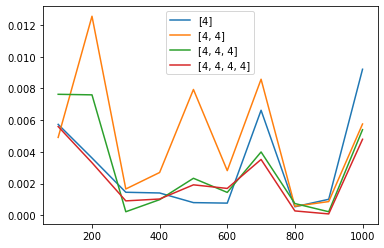

In [91]:
horizontal = list(range(1,len(Average_predict[0])+1))
horizontal = [a*100 for a in horizontal]
for a in Average_predict:
    for b in a:
        b = 1-b
        print(b)
for i in range(len(hiddenSize_all)):
    plt.plot(horizontal,Average_predict[i],label=str(hiddenSize_all[i]))

plt.legend()
plt.show()

In [82]:
for i in Average_predict:
    print(i)

[0.005735893757260295, 0.003617659365403341, 0.001457300581465031, 0.0014121378370715802, 0.0008049978434242233, 0.0007731271443403227, 0.006625792582087784, 0.0005431650866656806, 0.0010147560443175532, 0.009210038362882526]
[0.004914309601427394, 0.012551420068253506, 0.0016637235499451803, 0.002703634840396598, 0.007935770563151028, 0.0028203693561926896, 0.008580451914221956, 0.0005755150372996865, 0.0008698052743711631, 0.005759812901918665]
[0.007631947704257262, 0.0075969705176115445, 0.000229832545429104, 0.0009912248328498654, 0.002338495851434629, 0.001448047062981046, 0.003997465638435001, 0.0007460229889570459, 0.00022922977443970855, 0.0054003423299691655]
[0.005599836480938782, 0.0033195095938231556, 0.0009143212977487661, 0.001031955012110754, 0.0019254332765163992, 0.0016993167111481048, 0.0035255699537594517, 0.00028081221374150173, 9.262652487931261e-05, 0.004796692506126194]
